<a href="https://colab.research.google.com/github/ViacheslavTimofeev/Steel-production-research/blob/main/Steel_production_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Анализ и машинное обучение в производстве стали**



Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. Изучите его, прежде чем генерировать новые признаки.

## **Описание процесса обработки**



Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.
Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.
Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.
Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

## **Описание данных**


Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:

* `steel.data_arc` — данные об электродах;
* `steel.data_bulk` — данные об объёме сыпучих материалов;
* `steel.data_bulk_time` — данные о времени подачи сыпучих материалов;
* `steel.data_gas` — данные о продувке сплава газом;
* `steel.data_temp` — данные об измерениях температуры;
* `steel.data_wire` — данные об объёме проволочных материалов;
* `steel.data_wire_time` — данные о времени подачи проволочных материалов.

## **Основные условия по проекту**

* Целевой признак - последняя наблюдаемая температура.
* Нельзя использовать любые признаки, создаваемые из признака температуры, кроме финальной и стартовой температур.
* Удалить значения температуры ниже 1500.
* Значение MAE — ниже 6.8


# 1. Импорт необходимых библиотек и загрузка данных

In [ ]:
!pip install optuna
!pip install catboost

import pandas as pd
import sqlalchemy as db
from sqlalchemy import create_engine, text
import optuna
import shap
import time
import re
import numpy as np
from datetime import datetime, time, timedelta

import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.stattools import acf, pacf

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer, PowerTransformer
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, log_evaluation
from xgboost import XGBRegressor


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Подключимся к базе данных:

In [ ]:
db_login = {
    'username': 'praktikum_student',
    'pwd': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db_name': 'data-science-final'
    }

In [ ]:
db_config = {
'user': db_login['username'],
'pwd': db_login['pwd'],
'host': db_login['host'],
'port': db_login['port'],
'db': db_login['db_name']
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string)

conn = engine.connect()


Посмотрим на устройство базы данных. Выведем список схем:

In [ ]:
schemas_query = text("""SELECT nspname AS schema_name
FROM pg_namespace
WHERE nspname NOT IN ('pg_catalog', 'information_schema'); """)

schemas = conn.execute(schemas_query)

for row in schemas:
    print(row[0])


pg_toast
public
steel
telecom


Нас интересует схема steel. Выведем список таблиц в этой схеме.

In [ ]:
steel_tables_query = text("""SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'steel'
AND table_type = 'BASE TABLE'
""")

steel_tables = conn.execute(steel_tables_query)

for row in steel_tables:
    print(row[0])

data_arc
data_bulk
data_bulk_time
data_gas
data_temp
data_wire
data_wire_time


Теперь выведем количество значений для каждой таблицы:

In [ ]:
table_counts_query = text("""
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'steel'
AND table_type = 'BASE TABLE';
""")

tables = conn.execute(table_counts_query, {"schema_name": 'steel'}).fetchall()

# Формируем динамический SQL-запрос с UNION ALL
count_queries = [
    f"SELECT '{table.table_name}' AS table_name, COUNT(*) AS total_records FROM steel.{table.table_name}"
    for table in tables
]

# Объединяем все запросы в один с помощью UNION ALL
final_query = " UNION ALL ".join(count_queries)

# Выполняем финальный объединенный запрос
result = conn.execute(text(final_query))

# Выводим результаты
for row in result:
    print(row.table_name, row.total_records)

data_arc 14876
data_bulk 3129
data_bulk_time 3129
data_gas 3239
data_temp 15907
data_wire 3081
data_wire_time 3081


Создадим датафреймы из sql-запросов:

In [ ]:
%%time
query_arc = text("""
SELECT *
FROM steel.data_arc;
""")
data_arc = pd.read_sql_query(query_arc, con=conn)
#data_arc.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_arc.csv', index=False)

CPU times: user 163 ms, sys: 3.67 ms, total: 166 ms
Wall time: 1.22 s


In [ ]:
%%time
query_bulk = text("""
SELECT *
FROM steel.data_bulk;
""")
data_bulk = pd.read_sql_query(query_bulk, con=conn)
#data_bulk.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_bulk.csv', index=False)

CPU times: user 65.1 ms, sys: 0 ns, total: 65.1 ms
Wall time: 469 ms


In [ ]:
%%time
query_bulk_time = text("""
SELECT *
FROM steel.data_bulk_time;
""")
data_bulk_time = pd.read_sql_query(query_bulk_time, con=conn)
#data_bulk_time.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_bulk_time.csv', index=False)

CPU times: user 61.4 ms, sys: 6.87 ms, total: 68.3 ms
Wall time: 731 ms


In [ ]:
%%time
query_gas = text("""
SELECT *
FROM steel.data_gas;
""")
data_gas = pd.read_sql_query(query_gas, con=conn)
#data_gas.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_gas.csv', index=False)

CPU times: user 20 ms, sys: 741 µs, total: 20.8 ms
Wall time: 415 ms


In [ ]:
%%time
query_temp = text("""
SELECT *
FROM steel.data_temp;
""")
data_temp = pd.read_sql_query(query_temp, con=conn)
#data_temp.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_temp.csv', index=False)

CPU times: user 87 ms, sys: 3.84 ms, total: 90.8 ms
Wall time: 873 ms


In [ ]:
%%time
query_wire = text("""
SELECT *
FROM steel.data_wire;
""")
data_wire = pd.read_sql_query(query_wire, con=conn)
#data_wire.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_wire.csv', index=False)

CPU times: user 35 ms, sys: 2.53 ms, total: 37.5 ms
Wall time: 433 ms


In [ ]:
%%time
query_wire_time = text("""
SELECT *
FROM steel.data_wire_time;
""")
data_wire_time = pd.read_sql_query(query_wire_time, con=conn)
#data_wire_time.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_wire_time.csv', index=False)

CPU times: user 26.6 ms, sys: 2.13 ms, total: 28.8 ms
Wall time: 554 ms


Проведем исследовательский анализ данных и предобработку для каждой таблицы:

# 2. Анализ таблиц

## **data_arc**:

Пояснения к столбцам:
* **key** — номер партии;
* **BeginHeat** — время начала нагрева;
* **EndHeat** — время окончания нагрева;
* **ActivePower** — значение активной мощности;
* **ReactivePower** — значение реактивной мощности.

In [ ]:
data_arc = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_arc.csv')
print(data_arc.info())
print(data_arc.head())
data_arc = data_arc.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
   key BeginHeat   EndHeat  ActivePower  ReactivePower
0    1  11:02:14  11:06:02     0.976059       0.687084
1    1  11:07:28  11:10:33     0.805607       0.520285
2    1  11:11:44  11:14:36     0.744363       0.498805
3    1  11:18:14  11:24:19     1.659363       1.062669
4    1  11:26:09  11:28:37     0.692755       0.414397


Распределения значений:

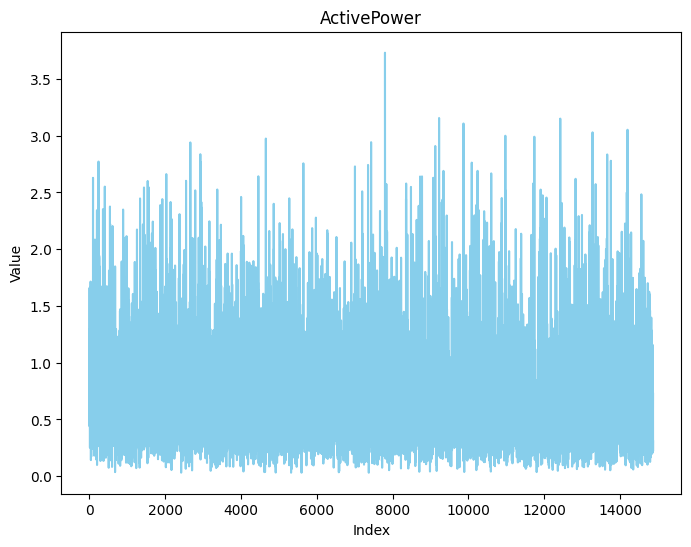

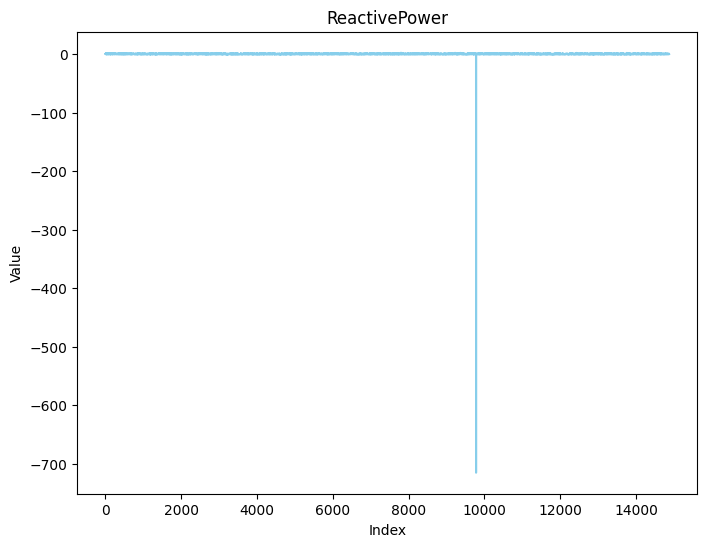

In [ ]:
for column in data_arc.drop(columns=['key', 'BeginHeat', 'EndHeat']).columns:
  plt.figure(figsize=(8, 6))
  plt.plot(data_arc[column], color='skyblue')
  plt.title(f"{column}")
  plt.xlabel("Index")
  plt.ylabel("Value")
  plt.show()

Аномальные значения ReactivePower:

In [ ]:
print(data_arc[data_arc['ReactivePower'] < 0])

       key BeginHeat   EndHeat  ActivePower  ReactivePower
9781  2116  00:44:48  00:46:37     0.495782    -715.504924


Удалим его:

In [ ]:
data_arc = data_arc.drop(data_arc[data_arc['ReactivePower'] < 0].index)

Снова посмотрим на распределение.

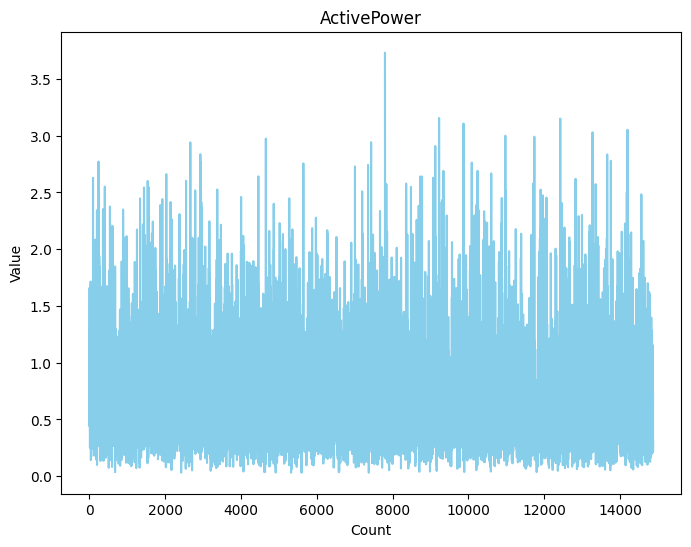

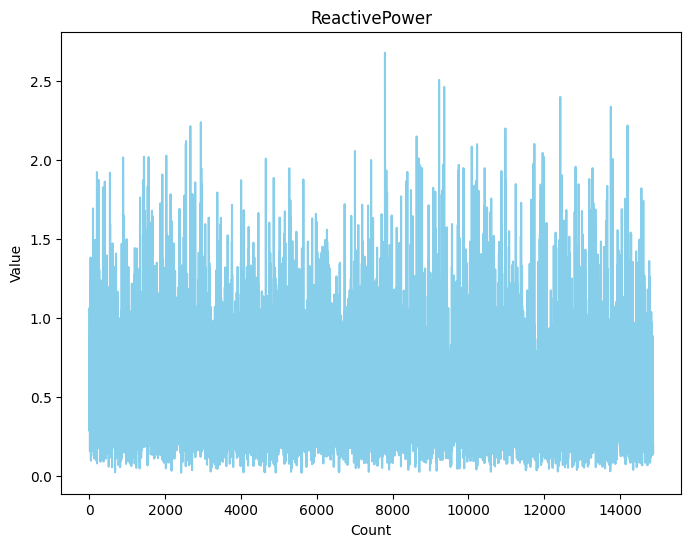

In [ ]:
for column in data_arc.drop(columns=['key', 'BeginHeat', 'EndHeat']).columns:
  plt.figure(figsize=(8, 6))
  plt.plot(data_arc[column], color='skyblue')
  plt.title(f"{column}")
  plt.xlabel("Count")
  plt.ylabel("Value")
  plt.show()

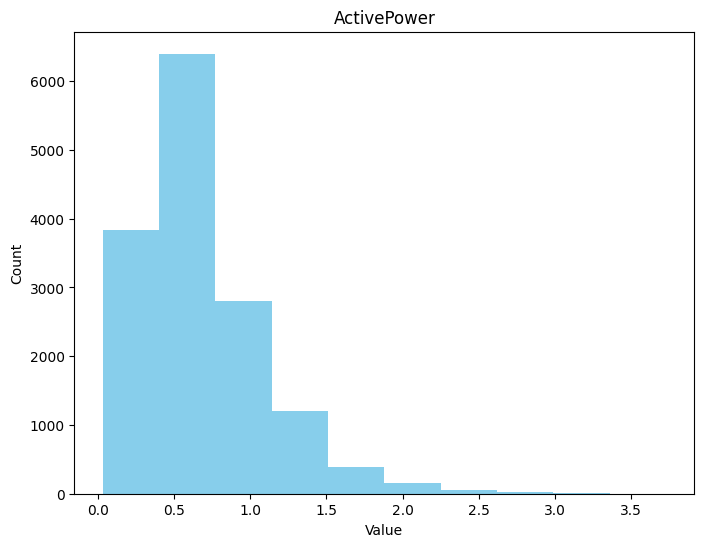

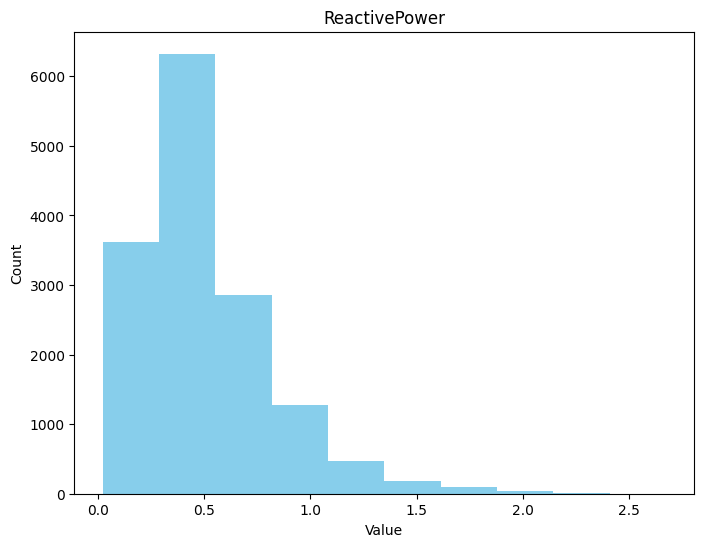

In [ ]:
for column in data_arc.drop(columns=['key', 'BeginHeat', 'EndHeat']).columns:
  plt.figure(figsize=(8, 6))
  plt.hist(data_arc[column], color='skyblue')
  plt.title(f"{column}")
  plt.xlabel("Value")
  plt.ylabel("Count")
  plt.show()

Создадим новые признаки:

`power_factor` — коэффициент мощности — это отношение активной мощности к полной мощности, и он показывает, насколько эффективно используется энергия. Значение близкое к 1 указывает на эффективное использование энергии.

`iterations_done` — количество совершенных циклов обработки стали для данной партии.

`mean_active_power`, `sum_active_power` — среднее и суммарное активные мощности для партии.

`mean_reactive_power`, `sum_reactive_power` — среднее и суммарные реактивные мощности для партии.

`mean_power_factor` — средний фактор мощности для партии.

`mean_seconds_heat`, `sum_seconds_heat` — среднее и суммарное количество секунд нагревания.


In [ ]:
def new_features(row):
  begin = datetime.combine(datetime.today(), row['BeginHeat'])
  end = datetime.combine(datetime.today(), row['EndHeat'])
  if end < begin: # проверка, относятся ли даты к разным дням, нужно для избежания наличия больших отрицательных значений в seconds_heat
    end += timedelta(days=1)
  seconds_heat = (end - begin).total_seconds()
  power_factor = row['ActivePower'] / (np.sqrt(row['ActivePower']**2 + row['ReactivePower']**2))

  return pd.Series([seconds_heat, power_factor])

In [ ]:
data_arc['BeginHeat'] = pd.to_datetime(data_arc['BeginHeat'], errors='coerce').dt.time
data_arc['EndHeat'] = pd.to_datetime(data_arc['EndHeat'], errors='coerce').dt.time

data_arc[['seconds_heat', 'power_factor']] = data_arc.apply(new_features, axis=1)
data_arc['iterations_done'] = (data_arc.sort_values(by=['key', 'BeginHeat'])
                                        .groupby('key')
                                        .cumcount() + 1)
print(data_arc.head())

<ipython-input-25-c1eef4f9a9d5>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_arc['BeginHeat'] = pd.to_datetime(data_arc['BeginHeat'], errors='coerce').dt.time
<ipython-input-25-c1eef4f9a9d5>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_arc['EndHeat'] = pd.to_datetime(data_arc['EndHeat'], errors='coerce').dt.time


   key BeginHeat   EndHeat  ActivePower  ReactivePower  seconds_heat  \
0    1  11:02:14  11:06:02     0.976059       0.687084         228.0   
1    1  11:07:28  11:10:33     0.805607       0.520285         185.0   
2    1  11:11:44  11:14:36     0.744363       0.498805         172.0   
3    1  11:18:14  11:24:19     1.659363       1.062669         365.0   
4    1  11:26:09  11:28:37     0.692755       0.414397         148.0   

   power_factor  iterations_done  
0      0.817717                1  
1      0.840041                2  
2      0.830728                3  
3      0.842115                4  
4      0.858178                5  


In [ ]:
data_arc = (data_arc
            .drop(columns=['BeginHeat', 'EndHeat'])
            .sort_values(by=['key'], ascending=True))

Агрегируем по ключу:

In [ ]:
data_arc_processed = data_arc.groupby('key').agg({
    'ActivePower': ['mean', 'sum'],
    'ReactivePower': ['mean', 'sum'],
    'power_factor': 'mean',
    'seconds_heat': ['mean', 'sum'],
    'iterations_done': 'max'
}).reset_index()

data_arc_processed.columns = [
'key',
'mean_active_power', 'sum_active_power',
'mean_reactive_power', 'sum_reactive_power',
'mean_power_factor',
'mean_seconds_heat', 'sum_seconds_heat',
'iterations_done'
]
print(data_arc_processed.head())

   key  mean_active_power  sum_active_power  mean_reactive_power  \
0    1           0.975629          4.878147             0.636648   
1    2           0.763150          3.052598             0.499528   
2    3           0.505176          2.525882             0.319815   
3    4           0.802313          3.209250             0.515074   
4    5           0.836793          3.347173             0.563161   

   sum_reactive_power  mean_power_factor  mean_seconds_heat  sum_seconds_heat  \
0            3.183241           0.837756             219.60            1098.0   
1            1.998112           0.840158             202.75             811.0   
2            1.599076           0.845421             131.00             655.0   
3            2.060298           0.841682             185.25             741.0   
4            2.252643           0.828104             217.25             869.0   

   iterations_done  
0                5  
1                4  
2                5  
3                4  

Сохраняем обработанный датасет в виде нового.

In [ ]:
#data_arc_processed.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_arc_processed.csv', index=False)

## **data_bulk**:

Пояснения к столбцам:
* **key** — номер партии;
* **Bulk 1 — Bulk 15** — объем подаваемого материала.

In [ ]:
data_bulk = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_bulk.csv')
print(data_bulk.info())
print(data_bulk.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1  

Удалять столбцы пока не будем, они помогут в создании новых признаков.

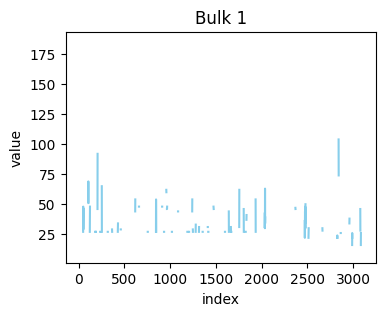

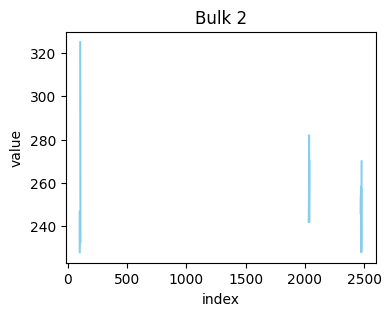

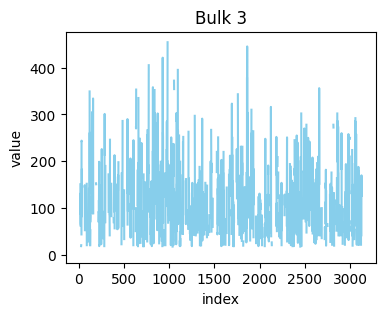

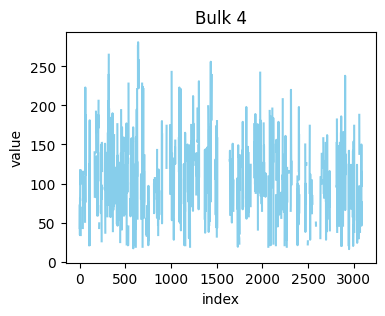

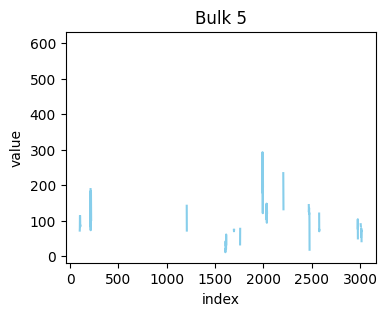

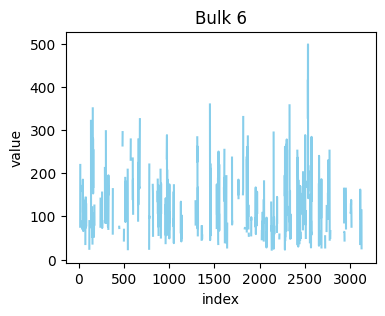

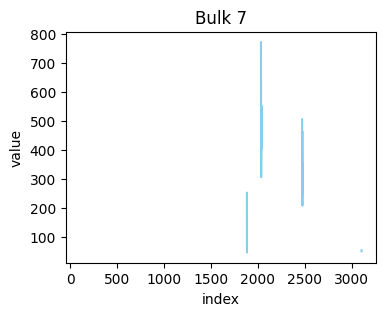

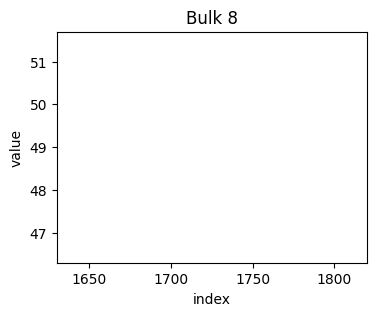

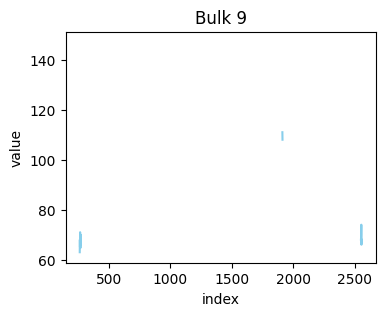

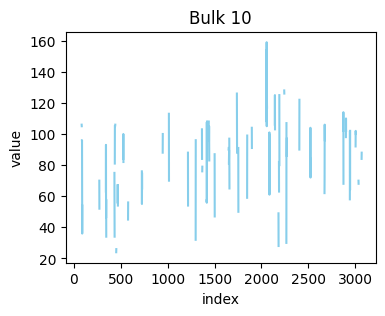

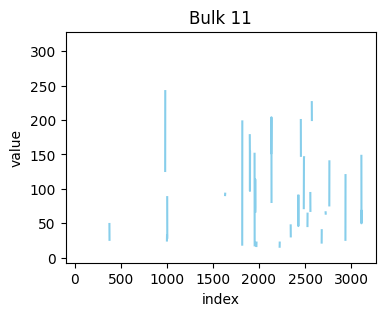

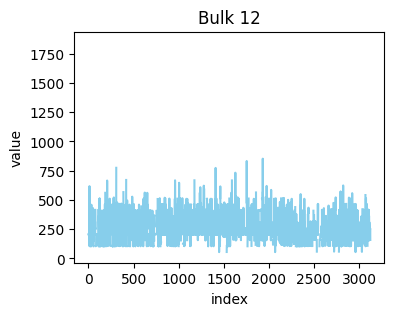

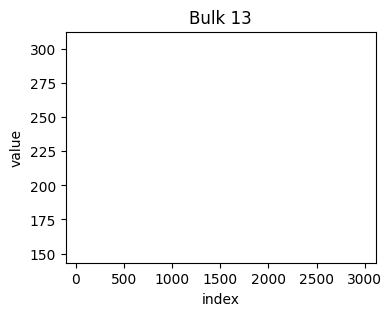

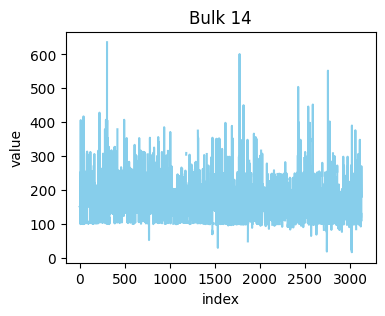

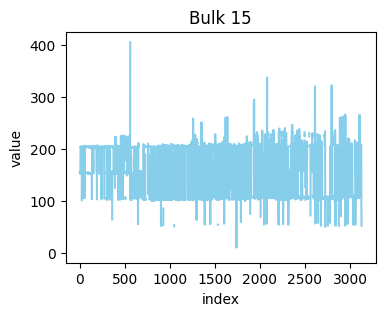

In [ ]:
for column in data_bulk.drop(columns=['key']).columns:
  plt.figure(figsize=(4, 3))
  plt.plot(data_bulk[column], color='skyblue')
  plt.title(f"{column}")
  plt.xlabel("index")
  plt.ylabel("value")
  plt.show()

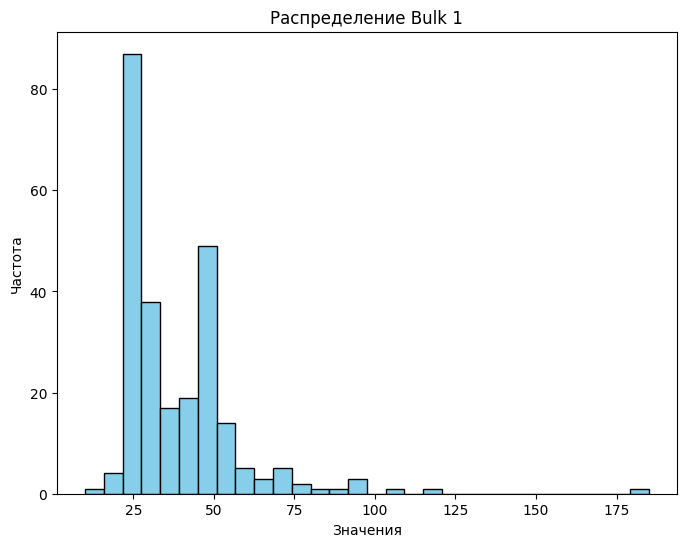

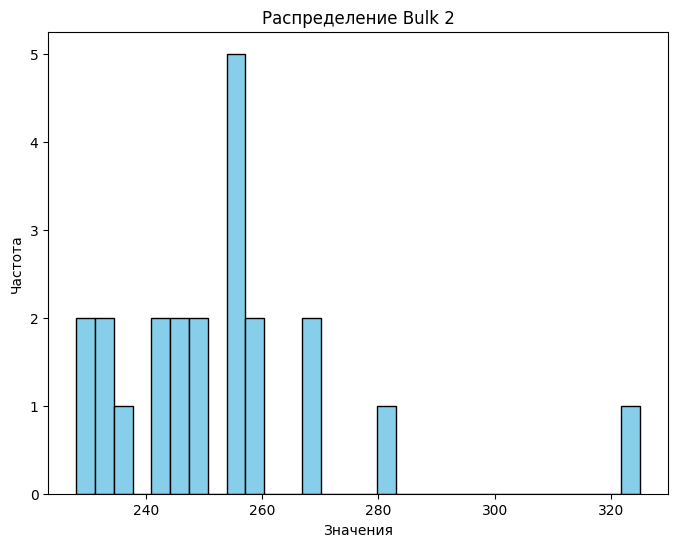

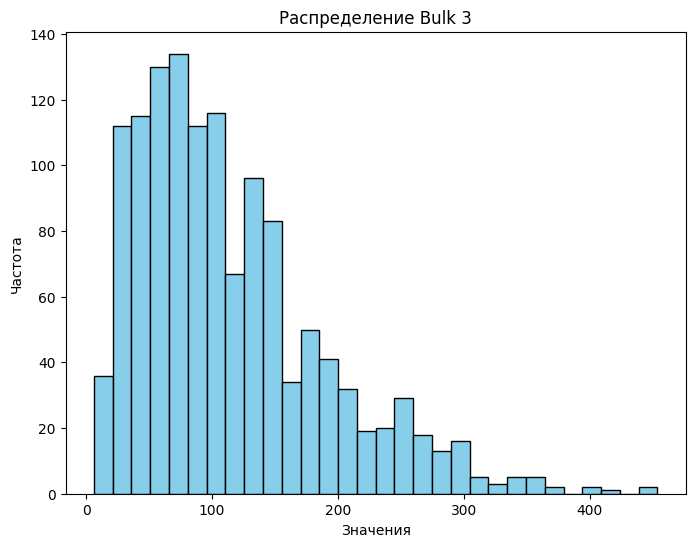

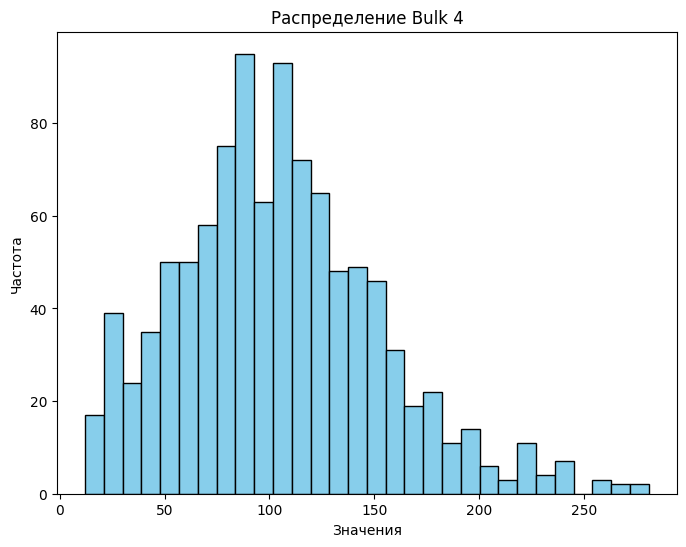

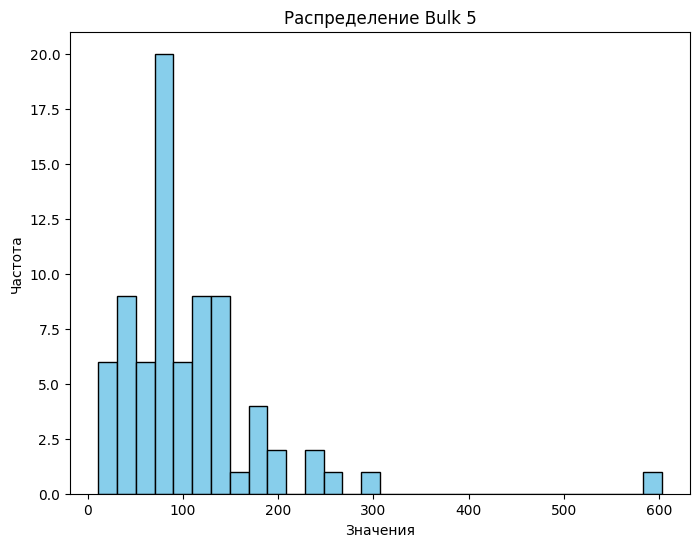

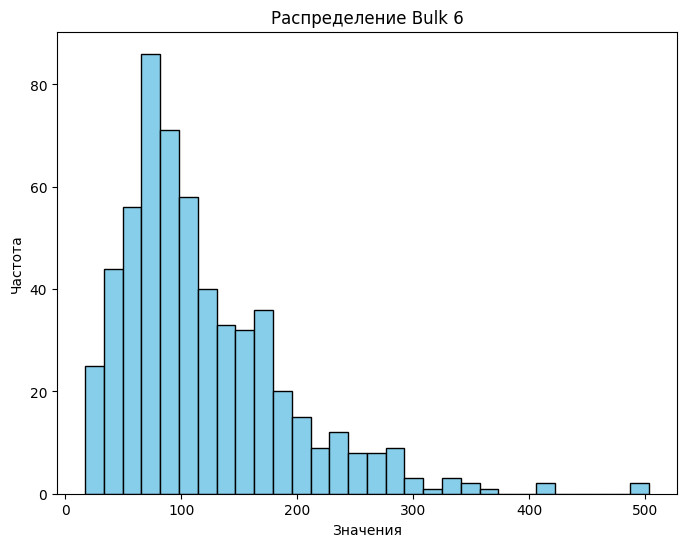

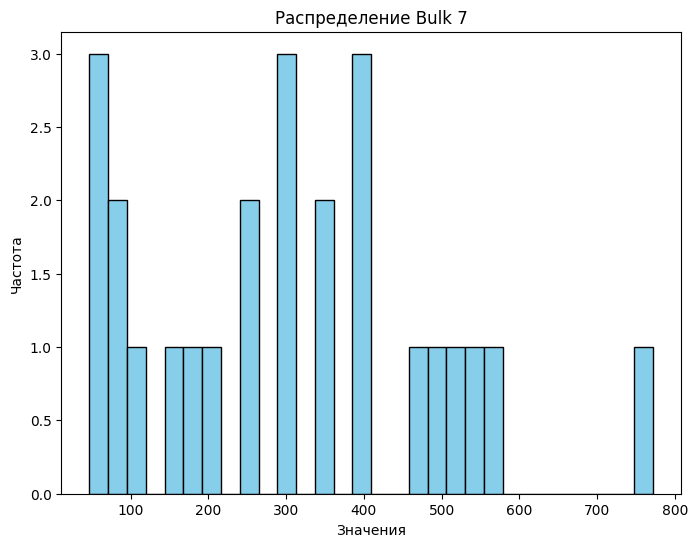

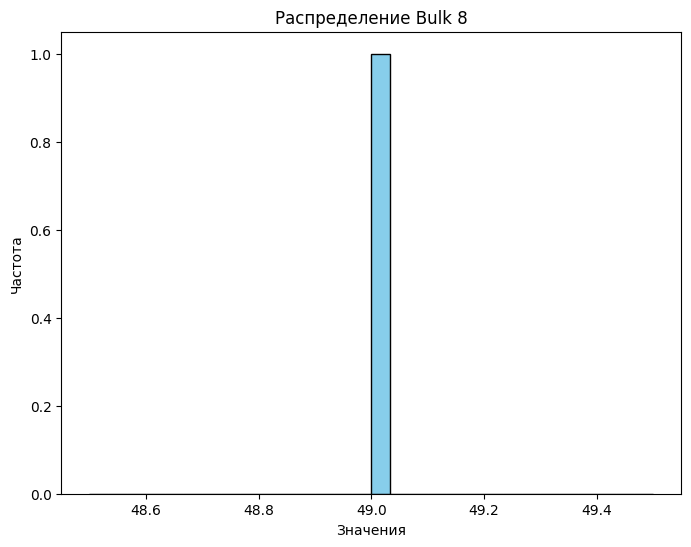

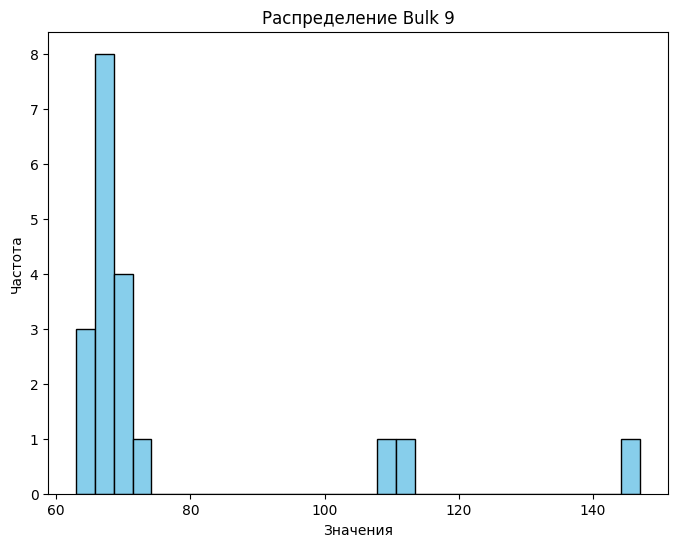

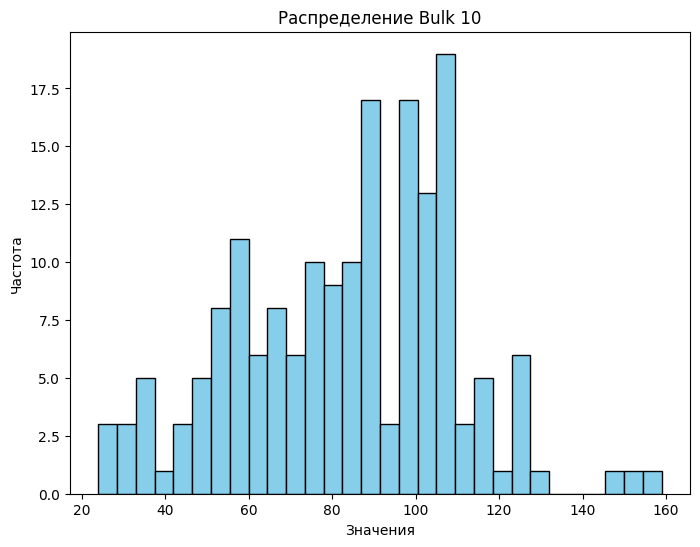

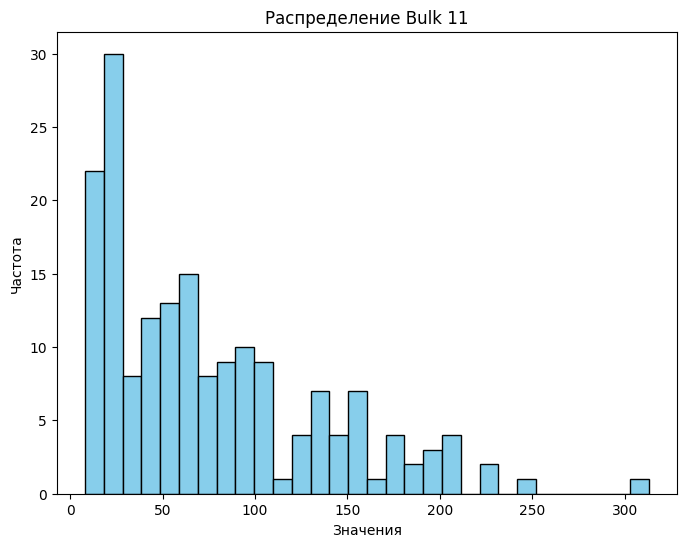

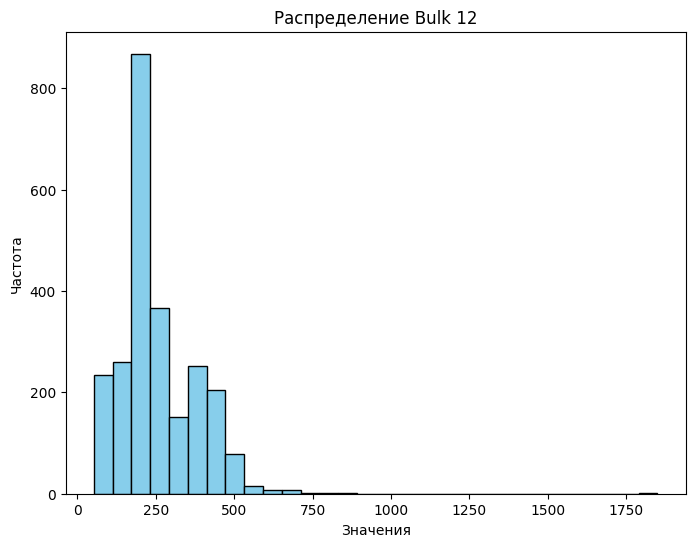

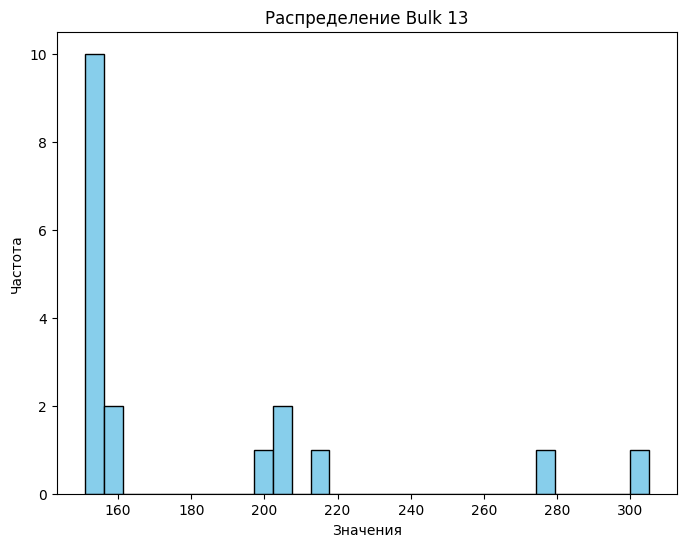

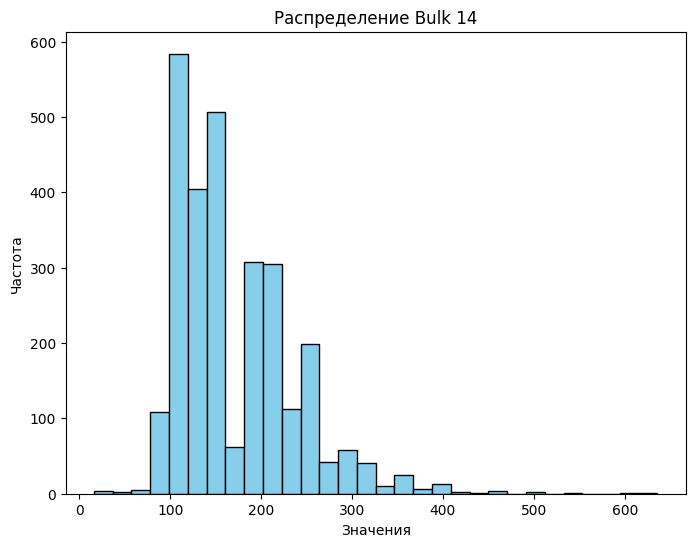

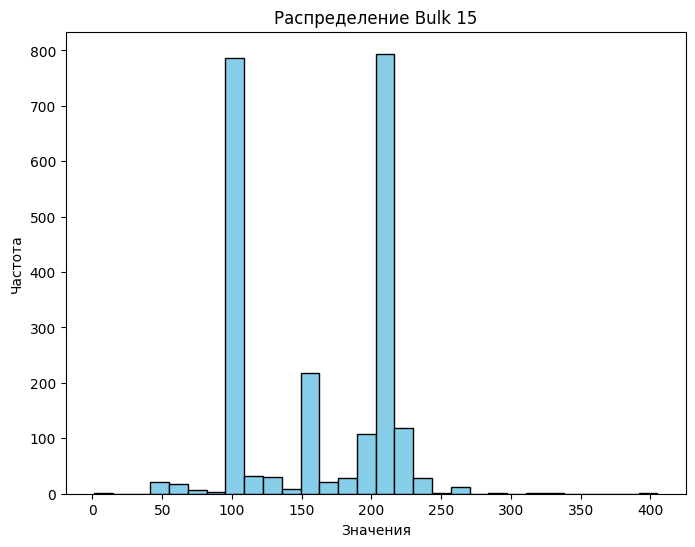

In [ ]:
for column in data_bulk.drop(columns=['key']).columns:
  plt.figure(figsize=(8, 6))
  plt.hist(data_bulk[column], bins=30, color='skyblue', edgecolor='black')
  plt.title(f"Распределение {column}")
  plt.xlabel("Значения")
  plt.ylabel("Частота")
  plt.show()

Распределения близки к логнормальным. Обработаем выбросы с учетом этого.

In [ ]:
def plot_boxplot_with_outliers(data, column, whis=1.5):
    """
    Создает boxplot с настраиваемыми усами и возвращает DataFrame с выбросами.

    Параметры:
    - data (pd.DataFrame): исходный датафрейм.
    - column (str): название столбца, по которому строится boxplot.
    - whis (float): множитель для определения усов (по умолчанию 1.5).

    Возвращает:
    - outliers: list с индексами выбросов для каждого столбца. Формат: [Index([1, 2, 3, 4], Index([5, 6, 7, 8], dtype='int64')]
    """
    # Получаем данные столбца
    col_data = data[column].dropna()  # убираем пропуски

    # Вычисление квартилей и межквартильного диапазона
    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1

    # Границы выбросов
    lower_bound = Q1 - whis * IQR
    upper_bound = Q3 + whis * IQR

    # Выбор выбросов
    outliers = col_data[(col_data < lower_bound) | (col_data > upper_bound)].index

    # Построение boxplot
    plt.figure(figsize=(8, 6))
    plt.boxplot(col_data, vert=False, whis=whis)
    plt.title(f'Boxplot for {column} (whis={whis})')
    plt.xlabel(column)
    plt.show()

    return outliers

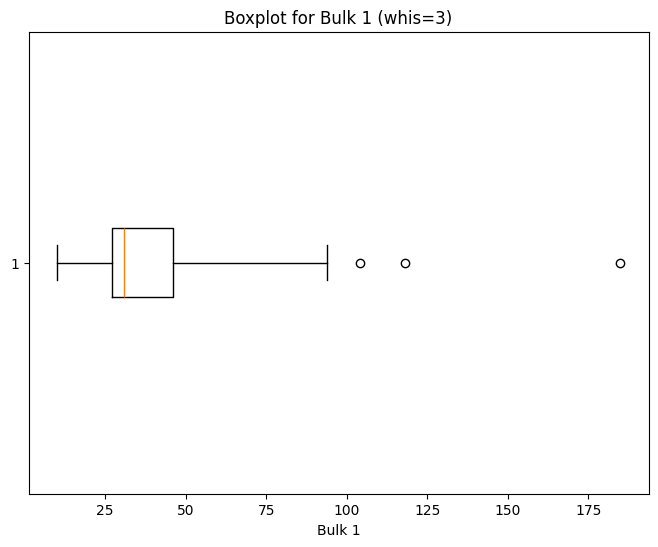

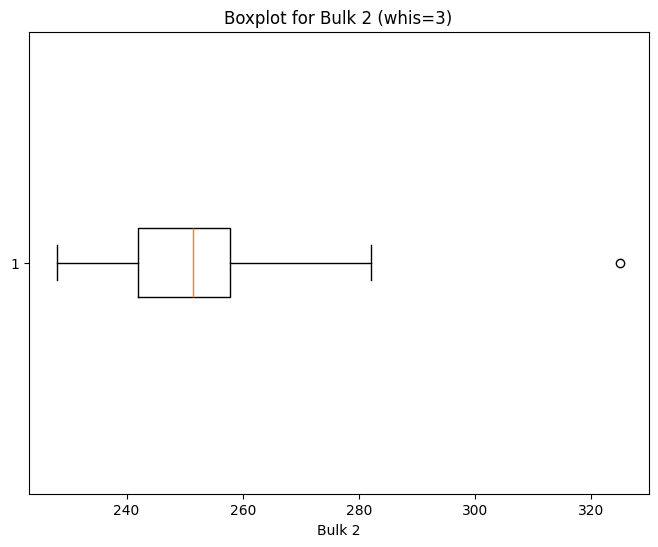

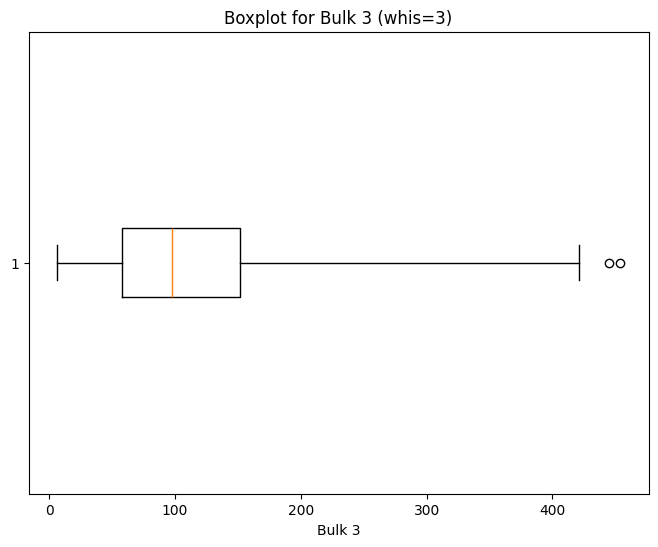

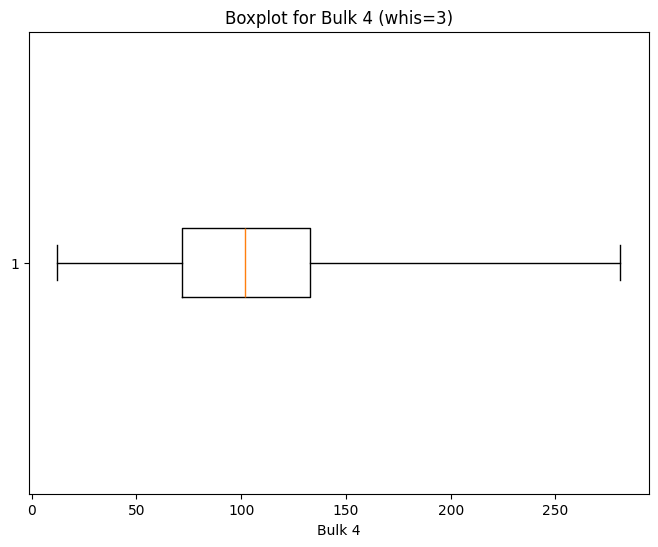

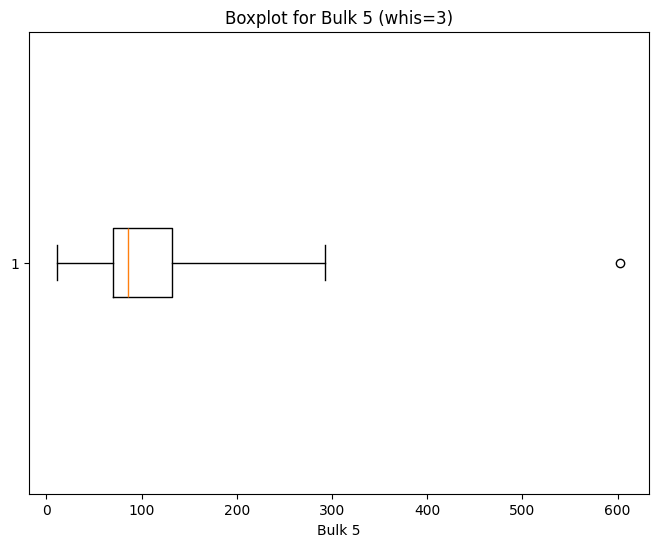

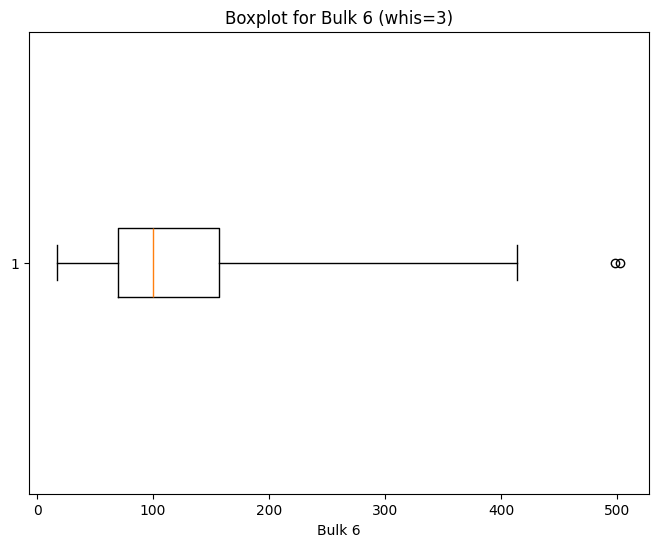

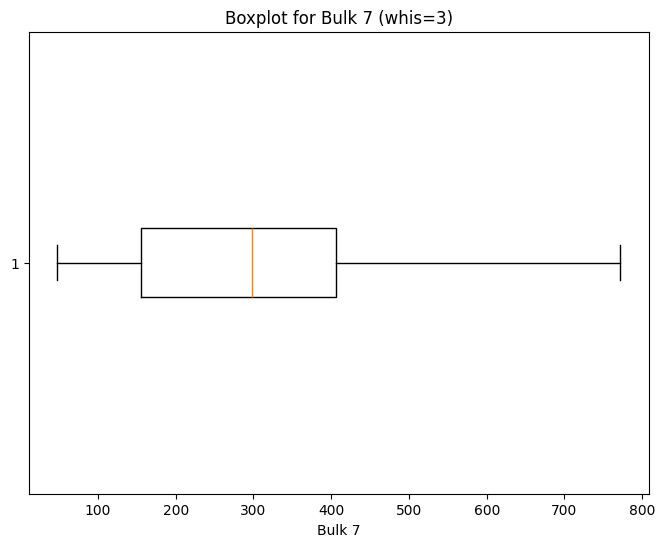

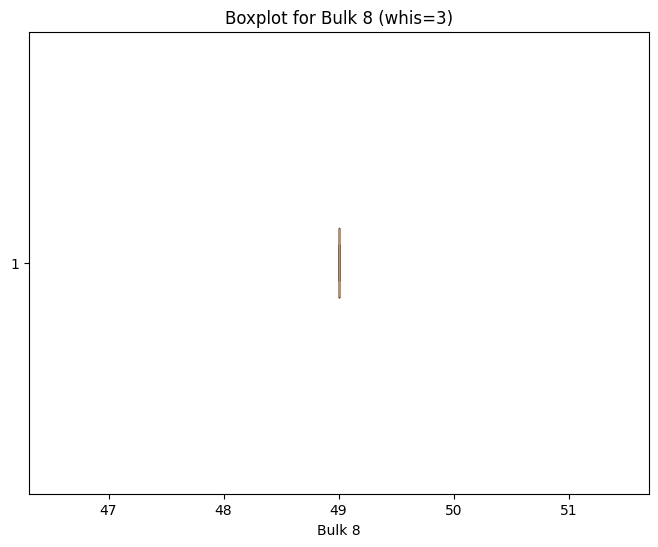

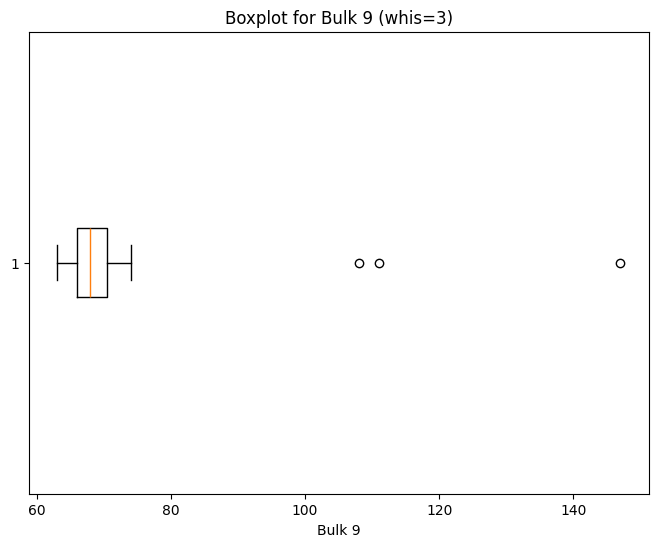

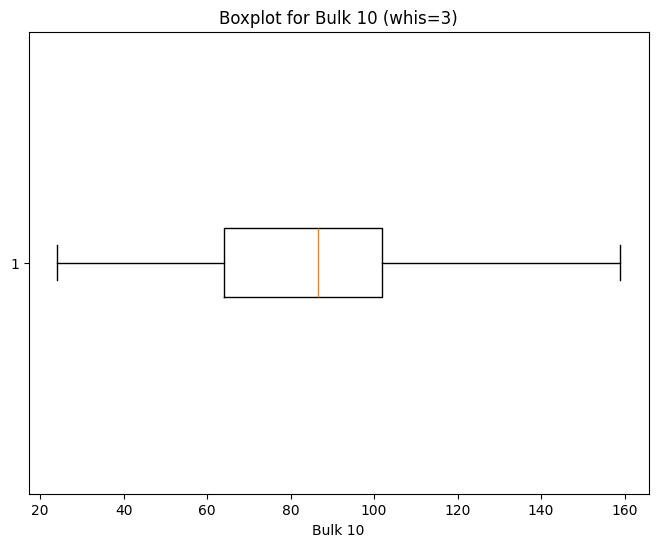

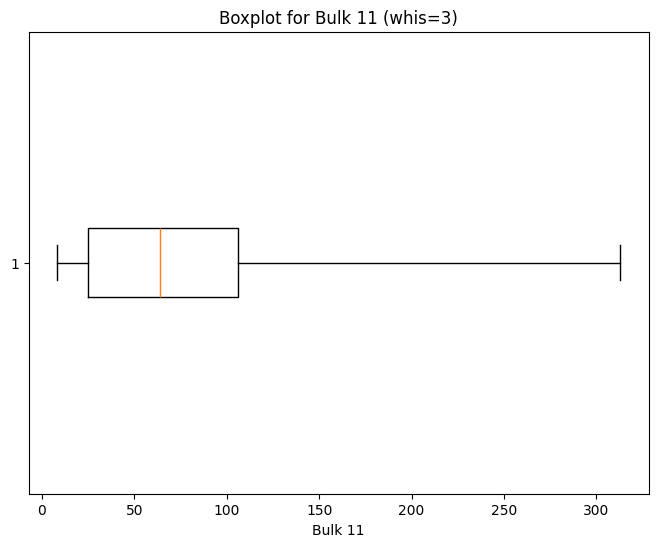

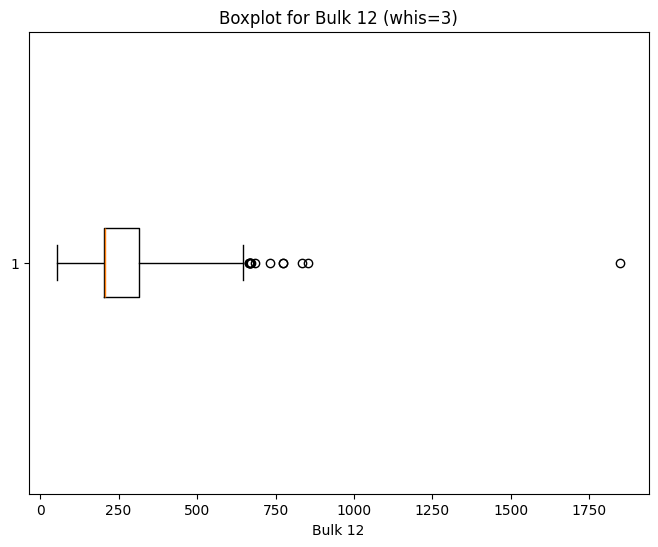

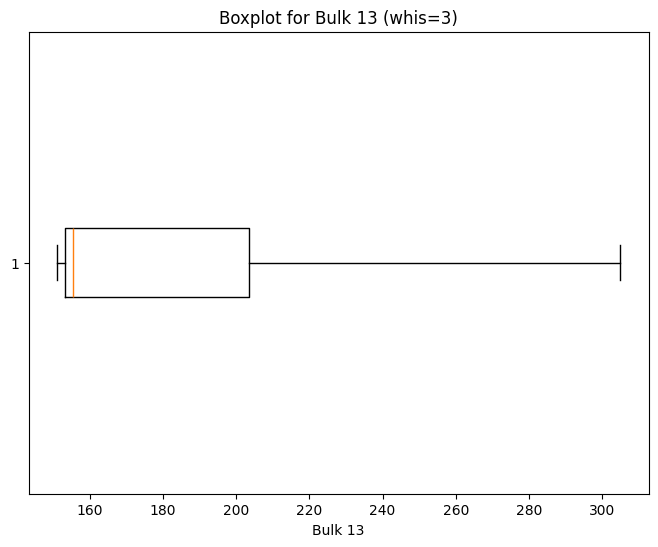

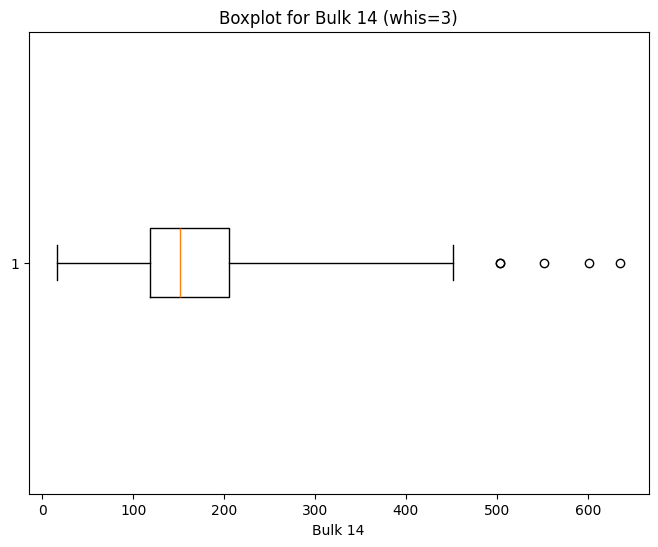

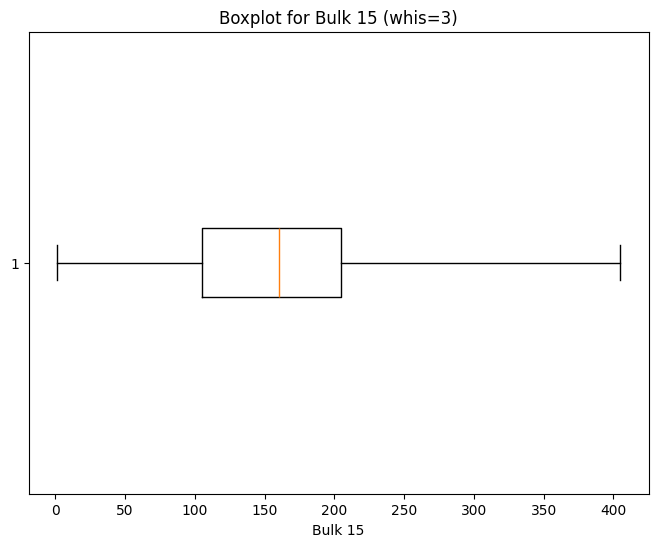

In [ ]:
outliers_idx_list_bulk = []
for column in data_bulk.drop('key', axis=1).columns:
  outliers = plot_boxplot_with_outliers(data_bulk, column, whis=3) # берем большой размер усов для boxplot
  outliers_idx_list_bulk.append(outliers)

outliers_idx = re.findall(r'\d+', str(outliers_idx_list_bulk))
outliers_idx = list(map(int, outliers_idx))  # Преобразование к целым числам

In [ ]:
print(data_bulk.shape, 'до удаления выбросов')
data_bulk = data_bulk.drop(outliers_idx).fillna(0).reset_index(drop=True)
print(data_bulk.shape, 'после удаления выбросов')

(3129, 16) до удаления выбросов
(3100, 16) после удаления выбросов


Добавим новых признаков:

`bulk_sum `— суммарное добавленное количество материалов для партии.

`bulk_mean`— среднее добавляемое количество материалов для партии.

In [ ]:
data_bulk['bulk_sum'] = data_bulk[data_bulk.columns.drop('key')].sum(axis=1, skipna=True) # суммарное добавленное количество материалов
data_bulk['bulk_mean'] = data_bulk[data_bulk.columns.drop('key')].mean(axis=1, skipna=True) # среднее добавляемое количество материалов для партии

In [ ]:
print(data_bulk.head())

   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3    4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4    5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  bulk_sum  \
0     0.0      0.0      0.0    206.0      0.0    150.0    154.0     553.0   
1     0.0      0.0      0.0    206.0      0.0    149.0    154.0     582.0   
2     0.0      0.0      0.0    205.0      0.0    152.0    153.0     544.0   
3     0.0      0.0      0.0    207.0      0.0    153.0    154.0     595.0   
4     0.0      0.0      0.0    203.0      0.0    151.0    152.0     584.0   

   bulk_mean  
0     69.125  
1     72.750  
2     68.000  
3     74.375  
4     73.000  


In [ ]:
#data_bulk.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_bulk_processed.csv', index=False)

 ## **data_bulk_time**:

Пояснения к столбцам:
* **key** — номер партии;
* **Bulk 1 — Bulk 15** — время подачи материала.

In [ ]:
data_bulk_time = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_bulk_time.csv')
print(data_bulk_time.info())
print(data_bulk_time.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
   key Bulk 1 Bulk 2 Bulk 3    Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
0    1    NaN    NaN    NaN  11:21:30    NaN    NaN    NaN    NaN    NaN   
1    2    NaN    

Изменим названия столбцов для совместимости со столбцами data_bulk в будущем:

In [ ]:
data_bulk_time = data_bulk_time.rename(columns={f'Bulk {i}': f'Bulk_{i}_time' for i in range(1, 16)})
data_bulk_time = data_bulk_time.dropna(axis=1, thresh=len(data_bulk_time)*0.5) # удалим столбцы, где количество пропусков больше 50%

Изменим тип данных на datetime:

In [ ]:
for column in data_bulk_time.drop(columns=['key']).columns:
    data_bulk_time[column] = pd.to_datetime(data_bulk_time[column], format='%H:%M:%S', errors='coerce').dt.time

In [ ]:
print(data_bulk_time.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           3129 non-null   int64 
 1   Bulk_12_time  2450 non-null   object
 2   Bulk_14_time  2806 non-null   object
 3   Bulk_15_time  2248 non-null   object
dtypes: int64(1), object(3)
memory usage: 97.9+ KB
None


In [ ]:
data_bulk_time = data_bulk_time.fillna(pd.Timestamp("0:00:00")).reset_index(drop=True) # заменим пропуски на значения Timedelta('0:00:00')

In [ ]:
print(data_bulk_time.head())

   key Bulk_12_time Bulk_14_time Bulk_15_time
0    1     11:03:52     11:03:52     11:03:52
1    2     11:40:20     11:40:20     11:40:20
2    3     12:09:40     12:09:40     12:09:40
3    4     12:41:24     12:41:24     12:41:24
4    5     13:12:56     13:12:56     13:12:56


In [ ]:
#data_bulk_time.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_bulk_time_processed.csv', index=False)

## **data_gas**:

Пояснения к столбцам:
* **key** — номер партии;
* **gas** — объем подаваемого газа.

In [ ]:
data_gas = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_gas.csv')
print(data_gas.info())
print(data_gas.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
   key        gas
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692


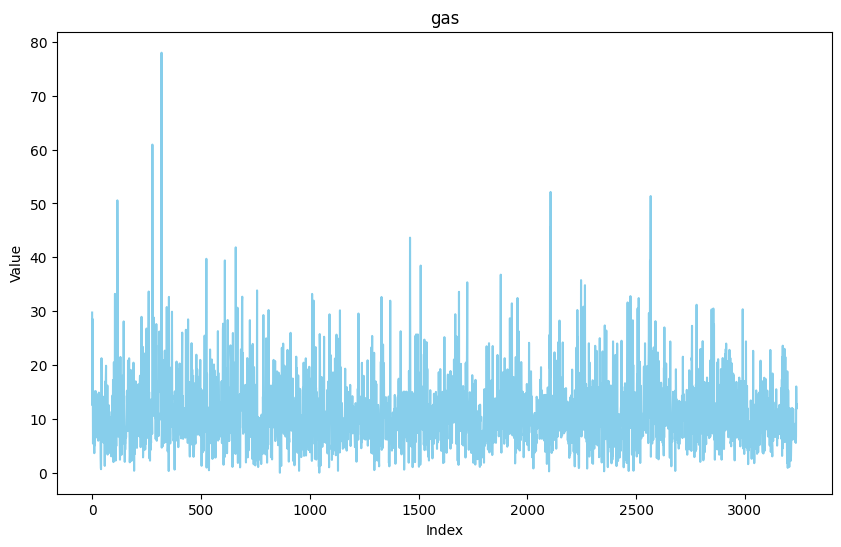

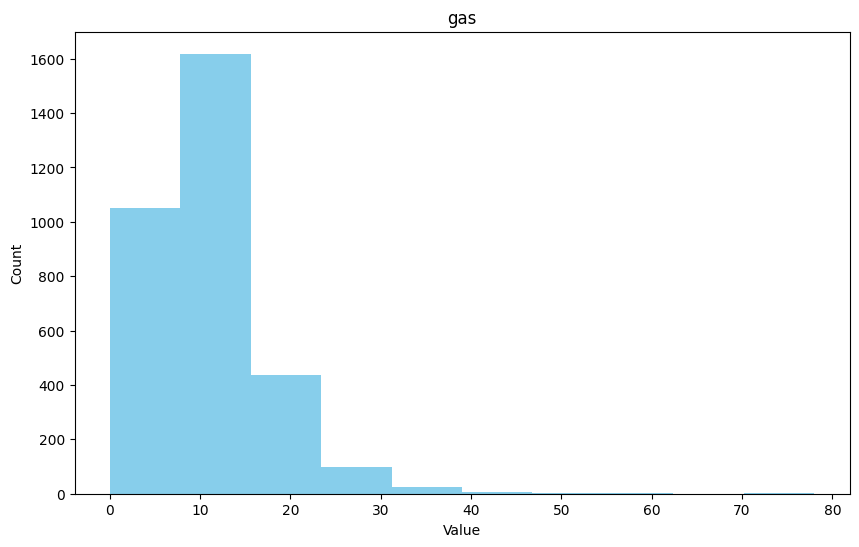

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data_gas['gas'], color='skyblue')
plt.title("gas")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(data_gas['gas'], color='skyblue')
plt.title("gas")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

Используем функцию, которую мы использовали для data_bulk, чтобы найти выбросы. Значение для размера усов также возьмем равное трем.

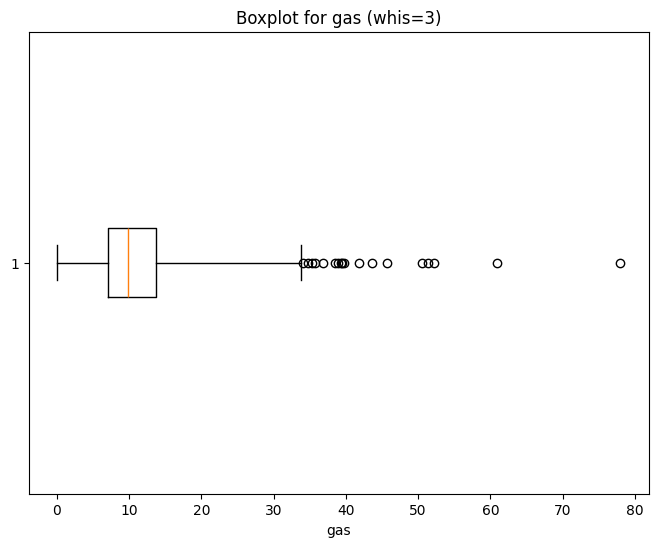

In [ ]:
outliers_idx_list_gas = [plot_boxplot_with_outliers(data_gas, 'gas', whis=3)]

In [ ]:
print(outliers_idx_list_gas)
outliers_idx_gas = re.findall(r'\d+', str(outliers_idx_list_gas))
outliers_idx_gas = list(map(int, outliers_idx_gas))

[Index([ 116,  117,  277,  278,  319,  525,  610,  660, 1461, 1510, 1724, 1878,
       2105, 2107, 2247, 2265, 2564, 2567],
      dtype='int64')]


In [ ]:
print(data_gas.shape, 'до удаления выбросов')
data_gas = data_gas.drop(outliers_idx_gas).reset_index(drop=True)
print(data_gas.shape, 'после удаления выбросов')

(3239, 2) до удаления выбросов
(3220, 2) после удаления выбросов


In [ ]:
#data_gas.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_gas_processed.csv', index=False)

## **data_temp**:

Пояснения к столбцам:
* **key** — номер партии;
* **MesaureTime** — время замера температуры;
* **Temperature** — температура.

In [ ]:
data_temp = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_temp.csv')
print(data_temp.info())
print(data_temp.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None
   key MesaureTime  Temperature
0    1    11:16:18       1571.0
1    1    11:25:53       1604.0
2    1    11:29:11       1618.0
3    1    11:30:01       1601.0
4    1    11:30:39       1613.0


Перименовываем столбцы, сортируем по времени.

In [ ]:
data_temp = data_temp.rename(columns={'MesaureTime': 'MeasureTime', 'Temperature': 'temp'}).sort_values(by=['key', 'MeasureTime']).reset_index(drop=True)

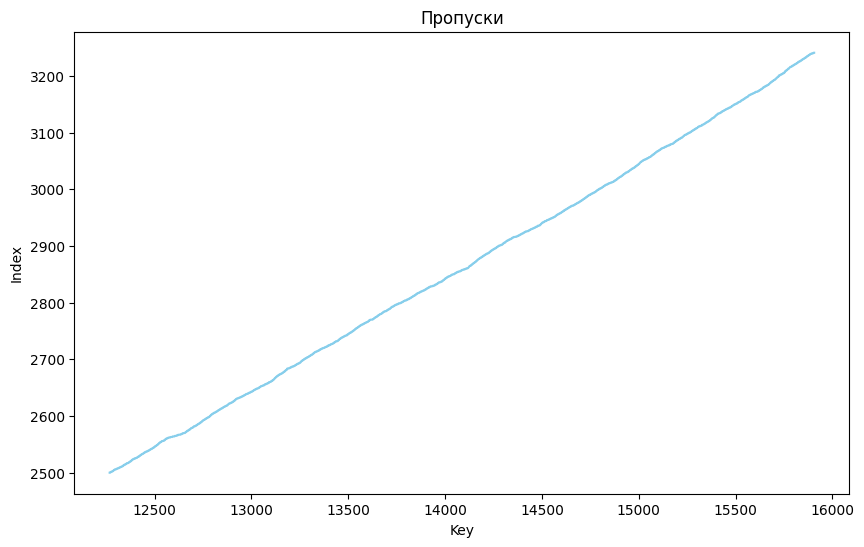

In [ ]:
nans = data_temp[data_temp['temp'].isna() == True]

plt.figure(figsize=(10, 6))
plt.plot(nans['key'], color='skyblue')
plt.title("Пропуски")
plt.xlabel("Key")
plt.ylabel("Index")
plt.show()

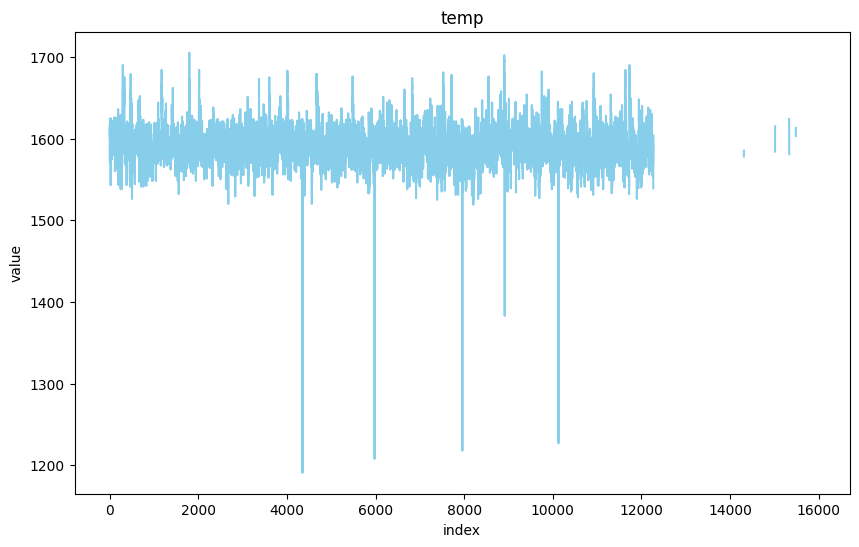

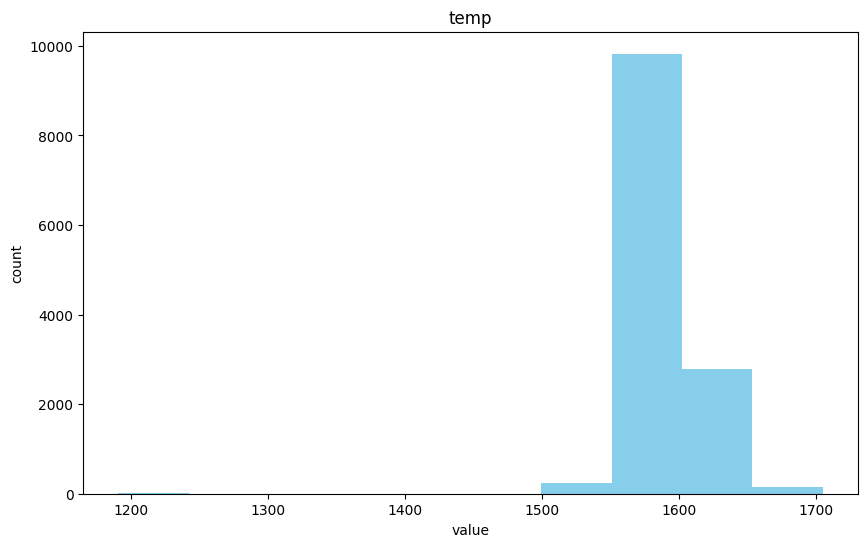

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data_temp['temp'], color='skyblue')
plt.title("temp")
plt.xlabel("index")
plt.ylabel("value")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(data_temp['temp'], color='skyblue')
plt.title("temp")
plt.xlabel("value")
plt.ylabel("count")
plt.show()

Большое количество пропусков после партии 2500. Решено не заменять пропущенные значения температуры на медиану, а просто удалить их. Все аномальные значения — ниже 1500 градусов, также удалим.

In [ ]:
data_temp = data_temp.groupby('key').filter(lambda group: not group['temp'].isna().any())
data_temp = data_temp.drop(data_temp[data_temp['temp'] < 1500].index)
data_temp['MeasureTime'] = pd.to_datetime(data_temp['MeasureTime'].astype(str))

<ipython-input-60-9b6a3e34421f>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_temp['MeasureTime'] = pd.to_datetime(data_temp['MeasureTime'].astype(str))


In [ ]:
print(data_temp.info())

<class 'pandas.core.frame.DataFrame'>
Index: 12261 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          12261 non-null  int64         
 1   MeasureTime  12261 non-null  datetime64[ns]
 2   temp         12261 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 383.2 KB
None


Создадим новые признаки:

`final_temp` — финальная температура. Целевой признак.

`start_temp` — стартовая температура.

`hour` — час дня от MeasureTime

In [ ]:
data_temp['final_temp'] = data_temp.groupby('key')['temp'].transform('last') # финальная температура
data_temp['start_temp'] = data_temp.groupby('key')['temp'].transform('first') # начальная температура
data_temp['hour'] = data_temp.groupby('key')['MeasureTime'].transform(lambda x: x.iloc[0].hour) # час дня
data_temp = data_temp.drop(['MeasureTime', 'temp'], axis=1).drop_duplicates().reset_index(drop=True)

In [ ]:
print(data_temp.head())

   key  final_temp  start_temp  hour
0    1      1613.0      1571.0    11
1    2      1602.0      1581.0    11
2    3      1599.0      1596.0    12
3    4      1625.0      1601.0    12
4    5      1602.0      1576.0    13


In [ ]:
#data_temp.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_temp_processed.csv', index=False)

## **data_wire**:

Пояснения к столбцам:
* **key** — номер партии;
* **Wire 1 - Wire 9** — объем подаваемых проволочных материалов.

In [ ]:
data_wire = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_wire.csv')
print(data_wire.info())
print(data_wire.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
   key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4 

Снова множества пропусков. Заменим на нули, пока не удаляем.

In [ ]:
data_wire = data_wire.fillna(0)

In [ ]:
print(data_wire)

       key      Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
0        1   60.059998  0.00000     0.0     0.0     0.0     0.0     0.0   
1        2   96.052315  0.00000     0.0     0.0     0.0     0.0     0.0   
2        3   91.160157  0.00000     0.0     0.0     0.0     0.0     0.0   
3        4   89.063515  0.00000     0.0     0.0     0.0     0.0     0.0   
4        5   89.238236  9.11456     0.0     0.0     0.0     0.0     0.0   
...    ...         ...      ...     ...     ...     ...     ...     ...   
3076  3237   38.088959  0.00000     0.0     0.0     0.0     0.0     0.0   
3077  3238   56.128799  0.00000     0.0     0.0     0.0     0.0     0.0   
3078  3239  143.357761  0.00000     0.0     0.0     0.0     0.0     0.0   
3079  3240   34.070400  0.00000     0.0     0.0     0.0     0.0     0.0   
3080  3241   63.117595  0.00000     0.0     0.0     0.0     0.0     0.0   

      Wire 8  Wire 9  
0        0.0     0.0  
1        0.0     0.0  
2        0.0     0.0  
3      

Создадим признаки: среднее количество добавленных материалов и суммарное.

In [ ]:
data_wire['wire_sum'] = data_wire[data_wire.columns.drop('key')].sum(axis=1, skipna=True) # суммарное добавленное количество материалов
data_wire['wire_mean'] = data_wire[data_wire.columns.drop('key')].mean(axis=1, skipna=True) # среднее добавляемое количество материалов для партии

In [ ]:
#data_wire.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_wire_processed.csv', index=False)

## **data_wire_time**:

Пояснения к столбцам:
* **key** — номер партии;
* **Wire 1 - Wire 9** — время добавления проволочных материалов.

In [ ]:
data_wire_time = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_wire_time.csv')
print(data_wire_time.info())
print(data_wire_time.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
   key    Wire 1    Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8 Wire 9
0    1  11:11:41       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
1    2  11:46:10       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
2    3  12:13:47       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
3    4  12:48:05       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
4    5  13:18:15  13:32:

Проделаем то же, что и для таблицы data_wire:

In [ ]:
data_wire_time = data_wire_time.rename(columns={f'Wire {i}': f'Wire_{i}_time' for i in range(1, 10)})
data_wire_time = data_wire_time.dropna(axis=1, thresh=len(data_wire_time)*0.5)

In [ ]:
data_wire_time = data_wire_time.fillna(pd.Timestamp("0:00:00")).reset_index(drop=True)
for column in data_wire_time.drop(columns=['key']).columns:
    data_wire_time[column] = pd.to_datetime(data_wire_time[column], errors='coerce').dt.time

<ipython-input-45-5f1100146a88>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_wire_time[column] = pd.to_datetime(data_wire_time[column], errors='coerce').dt.time


In [ ]:
print(data_wire_time.head())

       key Wire_1_time
0        1    11:11:41
1        2    11:46:10
2        3    12:13:47
3        4    12:48:05
4        5    13:18:15
...    ...         ...
3076  3237    22:50:20
3077  3238    23:38:24
3078  3239    01:50:43
3079  3240    03:12:02
3080  3241    04:16:01

[3081 rows x 2 columns]


In [ ]:
#data_wire_time.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_wire_time_processed.csv', index=False)

## **Объединение таблиц**:

In [ ]:
data_arc_processed = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_arc_processed.csv')
data_bulk_processed = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_bulk_processed.csv')
data_bulk_time_processed = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_bulk_time_processed.csv')
data_gas_processed = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_gas_processed.csv')
data_temp_processed = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_temp_processed.csv')
data_wire_processed = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_wire_processed.csv')
data_wire_time_processed = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_wire_time_processed.csv')

In [ ]:
print(data_arc_processed.shape)
print(data_bulk_processed.shape)
print(data_bulk_time_processed.shape)
print(data_gas_processed.shape)
print(data_temp_processed.shape)
print(data_wire_processed.shape)
print(data_wire_time_processed.shape)

(3214, 9)
(3100, 18)
(3129, 4)
(3220, 2)
(2477, 4)
(3081, 12)
(3081, 2)


In [ ]:
data_merged = (data_temp_processed
         .merge(data_arc_processed, on='key')
         .merge(data_bulk_processed, on='key')
         .merge(data_bulk_time_processed, on='key')
         .merge(data_gas_processed, on='key')
         .merge(data_wire_processed, on='key')
         .merge(data_wire_time_processed, on='key'))

In [ ]:
data_merged = data_merged.rename(columns={'Bulk 3_x': 'Bulk 3', 'Bulk 4_x': 'Bulk 4', 'Bulk 12_x': 'Bulk 12', 'Bulk 14_x': 'Bulk 14', 'Bulk 15_x': 'Bulk 15', 'Bulk 3_y': 'Bulk_time_3', 'Bulk 4_y': 'Bulk_time_4', 'Bulk 12_y': 'Bulk_time_12', 'Bulk 14_y': 'Bulk_time_14', 'Bulk 15_y': 'Bulk_time_15', 'Wire 1_x': 'Wire 1', 'Wire 2_x': 'Wire 2', 'Wire 1_y': 'Wire_time_1', 'Wire 2_y': 'Wire_time_2'})

In [ ]:
print(data_merged.head())
print(data_merged.columns)

   key  final_temp  start_temp  hour  mean_active_power  sum_active_power  \
0    1      1613.0      1571.0    11           0.975629          4.878147   
1    2      1602.0      1581.0    11           0.763150          3.052598   
2    3      1599.0      1596.0    12           0.505176          2.525882   
3    4      1625.0      1601.0    12           0.802313          3.209250   
4    5      1602.0      1576.0    13           0.836793          3.347173   

   mean_reactive_power  sum_reactive_power  mean_power_factor  \
0             0.636648            3.183241           0.837756   
1             0.499528            1.998112           0.840158   
2             0.319815            1.599076           0.845421   
3             0.515074            2.060298           0.841682   
4             0.563161            2.252643           0.828104   

   mean_seconds_heat  ...  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0             219.60  ...     0.0     0.0     0.0     0.0     0.0    

In [ ]:
#data_merged.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_merged_2.csv', index=False)

NameError: name 'data' is not defined

# 3. Обработка признаков

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/data_merged_2.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2293 non-null   int64  
 1   final_temp           2293 non-null   float64
 2   start_temp           2293 non-null   float64
 3   hour                 2293 non-null   int64  
 4   mean_active_power    2293 non-null   float64
 5   sum_active_power     2293 non-null   float64
 6   mean_reactive_power  2293 non-null   float64
 7   sum_reactive_power   2293 non-null   float64
 8   mean_power_factor    2293 non-null   float64
 9   mean_seconds_heat    2293 non-null   float64
 10  sum_seconds_heat     2293 non-null   float64
 11  iterations_done      2293 non-null   int64  
 12  Bulk 1               2293 non-null   float64
 13  Bulk 2               2293 non-null   float64
 14  Bulk 3               2293 non-null   float64
 15  Bulk 4               2293 non-null   f

Для правильной обработки временных признаков, мы преобразуем их в количественные. Так как далее разделять признаки на час, минуты и секунды будет ресурсоемко, возьмем количество секунд с начала дня, далее масштабируем.

In [ ]:
temp_features = ['Bulk_1_time', 'Bulk_2_time', 'Bulk_3_time',
                 'Bulk_4_time', 'Bulk_5_time', 'Bulk_6_time',
                 'Bulk_7_time', 'Bulk_8_time', 'Bulk_9_time',
                 'Bulk_10_time', 'Bulk_11_time', 'Bulk_12_time',
                 'Bulk_13_time', 'Bulk_14_time', 'Bulk_15_time',
                 'Wire_1_time', 'Wire_2_time', 'Wire_3_time',
                 'Wire_4_time', 'Wire_5_time', 'Wire_6_time',
                 'Wire_7_time', 'Wire_8_time', 'Wire_9_time']

# функция, преобразующая время в количество секунд с начала дня
def seconds_from_day_start(data, column):
    data[column] = pd.to_datetime(data[column], errors='coerce')
    return data[column].dt.hour * 3600 + data[column].dt.minute * 60 + data[column].dt.second

# Применение преобразования к каждому временному признаку
for feature in data.columns:
    if feature in temp_features:
      data[feature] = seconds_from_day_start(data, feature)

# Новые признаки для v2
data['temp_sqrt'] = np.sqrt(abs(data['start_temp'])) # корень из температуры
data['temp_log'] = np.log1p(data['start_temp']) # натуральный логарифм от "значение" + 1

# Удалим признаки с пропусками более 50%
data = data.drop(columns=data.columns[(data == 0).sum() > 0.5 * len(data)])
print(data.info())
print(data.head())

<ipython-input-11-632c1f56b0e2>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[column] = pd.to_datetime(data[column], errors='coerce')
<ipython-input-11-632c1f56b0e2>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[column] = pd.to_datetime(data[column], errors='coerce')
<ipython-input-11-632c1f56b0e2>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[column] = pd.to_datetime(data[column], errors='coerce')
<ipython-input-11-632c1f56b0e2>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To en

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2293 non-null   int64  
 1   final_temp           2293 non-null   float64
 2   start_temp           2293 non-null   float64
 3   hour                 2293 non-null   int64  
 4   mean_active_power    2293 non-null   float64
 5   sum_active_power     2293 non-null   float64
 6   mean_reactive_power  2293 non-null   float64
 7   sum_reactive_power   2293 non-null   float64
 8   mean_power_factor    2293 non-null   float64
 9   mean_seconds_heat    2293 non-null   float64
 10  sum_seconds_heat     2293 non-null   float64
 11  iterations_done      2293 non-null   int64  
 12  Bulk 12              2293 non-null   float64
 13  Bulk 14              2293 non-null   float64
 14  Bulk 15              2293 non-null   float64
 15  bulk_sum             2293 non-null   f

## Масштабирование

Для разных распределений подойдут разные типы масштабирования. Ниже мы создаем класс, который сначала выполняет масштабирование признаков в зависимости от распределения, а затем еще раз масштабирует в нужный диапазон (от -1 до 1 в нашем случае). Это поможет в дальнейшем использовании моделей, чувствительных к масштабу.

In [ ]:
class UnifiedScaler:
    """
    Класс для масштабирования признаков с предварительной проверкой данных
    """
    def __init__(self, target_range=(-1, 1)):
        self.target_range = target_range
        self.initial_scalers = None
        self.final_scaler = None
        self.feature_types = {}
        self.shift_values = {}  # Для хранения значений сдвига

    def _make_positive(self, series):
        """
        Преобразует данные в положительные, сохраняя относительные расстояния
        """
        min_val = series.min()
        if min_val <= 0:
            shift = abs(min_val) + 1  # +1 чтобы избежать нулей
            return series + shift, shift
        return series, 0

    def _analyze_features(self, df):
        """
        Анализирует признаки и определяет подходящие преобразования
        """
        feature_analysis = {}

        for column in df.columns:
            data = df[column]

            # Базовые статистики
            stats = {
                'skew': data.skew(),  # коэффициент асимметрии
                'kurtosis': data.kurtosis(),  # коэффициент эксцесса
                'min': data.min(),
                'max': data.max(),
                'std': data.std(),  # стандартное отклонение
                'zeros': (data == 0).sum() / len(data),
                'negative': (data < 0).any()
            }

            # Определяем тип преобразования
            if stats['skew'] > 2:  # Сильная правосторонняя асимметрия
                if not stats['negative'] and stats['zeros'] < 0.1:
                    transform = 'log'  # Логарифмическое преобразование для данных с большим "хвостом". Делает экспоненциальный рост линейным
                elif stats['std'] / abs(data.mean()) > 0.5:  # Высокая относительная дисперсия
                    transform = 'yeo-johnson'  # Используем преобразование yeo-johnson — аналог Бокса-Кокса для данных с отрицательными значениями
                else:
                    transform = 'robust'
            elif stats['skew'] > 1:  # Умеренная асимметрия
                transform = 'yeo-johnson'
            elif stats['std'] / abs(data.mean()) > 1:  # Высокая вариация
                transform = 'robust'
            else:
                transform = 'standard'

            feature_analysis[column] = {
                'stats': stats,
                'recommended_transform': transform
            }

        return feature_analysis

    def _initial_transform(self, df):
        """
        Применяет первичные преобразования с учетом характеристик данных
        """
        feature_analysis = self._analyze_features(df)
        transformed_df = df.copy()

        for column, analysis in feature_analysis.items():
            method = analysis['recommended_transform']
            data = df[column]

            if method == 'log':
                # Для логарифмического преобразования
                positive_data, shift = self._make_positive(data)
                self.shift_values[column] = shift
                transformed_df[column] = np.log1p(positive_data)

            elif method == 'yeo-johnson':
                pt = PowerTransformer(method='yeo-johnson')
                transformed_df[column] = pt.fit_transform(data.values.reshape(-1, 1)).ravel()

            elif method == 'robust':
                scaler = RobustScaler()
                transformed_df[column] = scaler.fit_transform(data.values.reshape(-1, 1)).ravel()

            elif method == 'standard':
                scaler = StandardScaler()
                transformed_df[column] = scaler.fit_transform(data.values.reshape(-1, 1)).ravel()

        self.feature_types = feature_analysis
        return transformed_df

    def fit_transform(self, df):
        """
        Применяет подходящие преобразования и затем унифицирует масштабы
        """
        # Первичное преобразование признаков
        transformed_df = self._initial_transform(df)

        # Унификация масштабов
        unified_df = self._unify_scales(transformed_df)

        return unified_df

    def _unify_scales(self, df):
        """
        Унифицирует масштабы всех признаков до целевого диапазона
        """
        self.final_scaler = MinMaxScaler(feature_range=self.target_range)
        unified_data = self.final_scaler.fit_transform(df)
        return pd.DataFrame(unified_data, columns=df.columns)

    def visualize_transformations(self, original_df, transformed_df, unified_df):
        """
        Визуализирует распределения на каждом этапе преобразования
        """
        n_features = len(original_df.columns)
        fig, axes = plt.subplots(n_features, 3, figsize=(20, 5*n_features))
        if n_features == 1:
            axes = axes.reshape(1, -1)

        for idx, column in enumerate(original_df.columns):
            # Исходное распределение
            sns.histplot(original_df[column], ax=axes[idx, 0], bins=30)
            axes[idx, 0].set_title(f'{column} - Original')
            axes[idx, 0].set_xlabel(f'Skewness: {original_df[column].skew():.2f}')

            # После первичного преобразования
            sns.histplot(transformed_df[column], ax=axes[idx, 1], bins=30)
            axes[idx, 1].set_title(
                f'{column} - Transformed\n'
                f'Method: {self.feature_types[column]["recommended_transform"]}'
            )
            axes[idx, 1].set_xlabel(f'Skewness: {transformed_df[column].skew():.2f}')

            # После унификации масштаба
            sns.histplot(unified_df[column], ax=axes[idx, 2], bins=30)
            axes[idx, 2].set_title(f'{column} - Unified Scale')
            axes[idx, 2].set_xlabel(f'Skewness: {unified_df[column].skew():.2f}')

        plt.tight_layout()
        return fig

Применяем преобразования:

In [ ]:
X = data.drop('final_temp', axis=1)
y = data['final_temp']

scaler = UnifiedScaler(target_range=(-1, 1))
transformed_data = scaler._initial_transform(X)
unified_data = scaler._unify_scales(transformed_data)

In [ ]:
#unified_data.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/unified_data_1.csv', index=False)

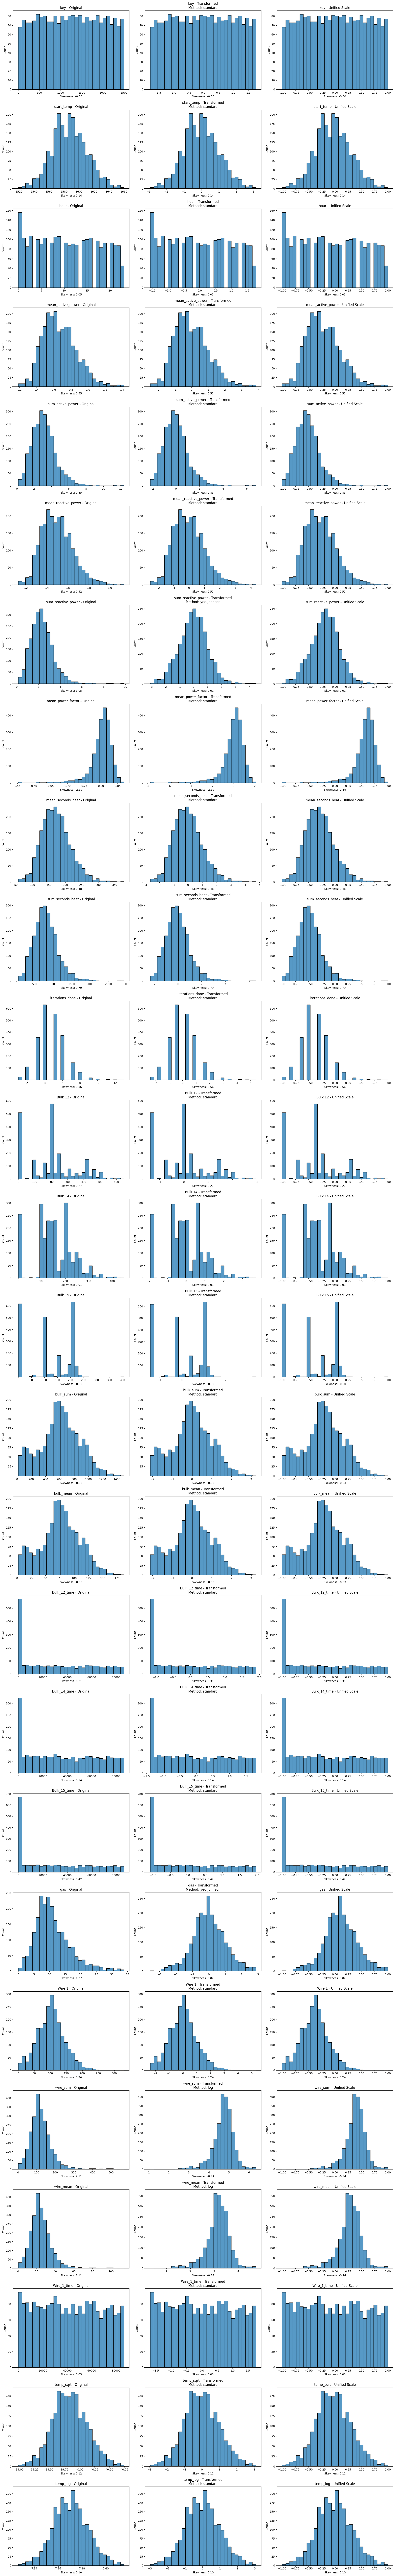


Feature: key
Transform method: standard

Feature: start_temp
Transform method: standard

Feature: hour
Transform method: standard

Feature: mean_active_power
Transform method: standard

Feature: sum_active_power
Transform method: standard

Feature: mean_reactive_power
Transform method: standard

Feature: sum_reactive_power
Transform method: yeo-johnson

Feature: mean_power_factor
Transform method: standard

Feature: mean_seconds_heat
Transform method: standard

Feature: sum_seconds_heat
Transform method: standard

Feature: iterations_done
Transform method: standard

Feature: Bulk 12
Transform method: standard

Feature: Bulk 14
Transform method: standard

Feature: Bulk 15
Transform method: standard

Feature: bulk_sum
Transform method: standard

Feature: bulk_mean
Transform method: standard

Feature: Bulk_12_time
Transform method: standard

Feature: Bulk_14_time
Transform method: standard

Feature: Bulk_15_time
Transform method: standard

Feature: gas
Transform method: yeo-johnson

Feat

In [ ]:
# Визуализируем результаты
fig = scaler.visualize_transformations((X), transformed_data, unified_data)
plt.show()

# Выводим информацию о преобразованиях
for column in X.columns:
    print(f"\nFeature: {column}")
    print(f"Transform method: {scaler.feature_types[column]['recommended_transform']}")
    if column in scaler.shift_values:
        print(f"Shift value: {scaler.shift_values[column]}")

## Отбор признаков

Сначала посмотрим коэффициенты корреляции с целевым призраком:

In [ ]:
unified_data = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/unified_data_1.csv', index=False)

In [ ]:
unified_data = unified_data.join(y)

In [ ]:
corr_pearson = unified_data.corr()['final_temp'].sort_values()
print(corr_pearson)

key                   -0.083411
Wire_1_time           -0.001343
hour                   0.010512
Bulk_14_time           0.021291
gas                    0.066062
Bulk_12_time           0.068663
Bulk 14                0.080324
Bulk_15_time           0.111389
wire_mean              0.122945
wire_sum               0.123599
mean_reactive_power    0.133102
mean_power_factor      0.151670
mean_seconds_heat      0.175641
iterations_done        0.175888
mean_active_power      0.191088
bulk_mean              0.213781
bulk_sum               0.213781
sum_reactive_power     0.221752
Bulk 15                0.249711
Bulk 12                0.255502
sum_seconds_heat       0.261609
sum_active_power       0.270568
Wire 1                 0.310638
start_temp             0.315353
temp_sqrt              0.315581
temp_log               0.315802
final_temp             1.000000
Name: final_temp, dtype: float64


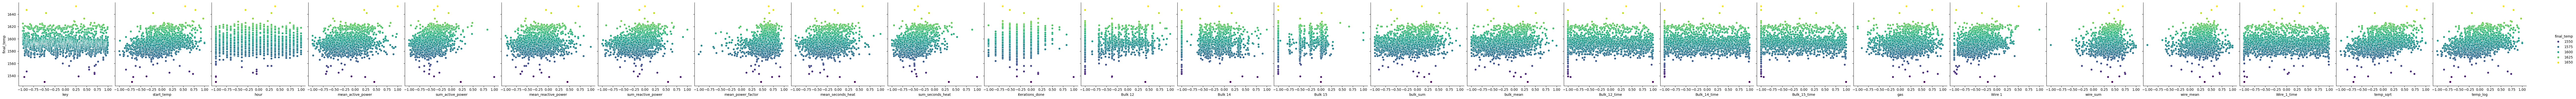

In [ ]:
sns.pairplot(unified_data, x_vars=unified_data.drop('final_temp', axis=1).columns, y_vars='final_temp', hue='final_temp', palette="viridis", height=4, aspect=1)

Только несколько признаков имеют сколь-нибудь значимый коэффициент. Четкой линейной зависимости нет.

Проверим высокие коэффициенты между разными признаками:

In [ ]:
# Создаем маску для отфильтрованных значений (оставляем только те, что выше порога по модулю и не равны 1)
corr_matrix = unified_data.corr()
filtered_corr = corr_matrix[(np.abs(corr_matrix) > 0.5) & (corr_matrix != 1.0)]

# Выводим признаки с коэффициентами корреляции выше порога
print("Признаки с коэффициентом корреляции более 0.5:")
for col in filtered_corr.columns:
    high_corr = filtered_corr[col].dropna()
    if not high_corr.empty:
        print(f"{col}:")
        for idx, val in high_corr.items():
            print(f"  {idx} — корреляция: {val:.2f}")

Признаки с коэффициентом корреляции более 0.3:
start_temp:
  mean_active_power — корреляция: -0.51
  temp_sqrt — корреляция: 1.00
  temp_log — корреляция: 1.00
hour:
  Bulk_12_time — корреляция: 0.60
  Bulk_14_time — корреляция: 0.72
  Bulk_15_time — корреляция: 0.55
  Wire_1_time — корреляция: 0.89
mean_active_power:
  start_temp — корреляция: -0.51
  sum_active_power — корреляция: 0.65
  mean_reactive_power — корреляция: 0.92
  sum_reactive_power — корреляция: 0.62
  mean_seconds_heat — корреляция: 0.95
  sum_seconds_heat — корреляция: 0.58
  temp_sqrt — корреляция: -0.51
  temp_log — корреляция: -0.51
sum_active_power:
  mean_active_power — корреляция: 0.65
  mean_reactive_power — корреляция: 0.59
  sum_reactive_power — корреляция: 0.95
  mean_seconds_heat — корреляция: 0.58
  sum_seconds_heat — корреляция: 0.98
  iterations_done — корреляция: 0.74
  bulk_sum — корреляция: 0.57
  bulk_mean — корреляция: 0.57
mean_reactive_power:
  mean_active_power — корреляция: 0.92
  sum_active_po

Между некоторыми признаками наблюдается четкая взаимосвязь.
Удалим признаки, сильно коррелирующие с другими.

In [ ]:
# Признаки, производные от start_temp, дают ту же информацию. Признак wire_mean показывает ту же информацию, что и wire_sum.
unified_data = unified_data.drop(columns=['temp_sqrt', 'temp_log', 'wire_mean'])

In [ ]:
#unified_data.to_csv('/content/drive/MyDrive/Datasets/steel_production_project/unified_data_2.csv', index=False)

Теперь, используя случайный лес, попытаемся найти нелинейные связи:

In [ ]:
unified_data = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/unified_data_2.csv', index_col=0)

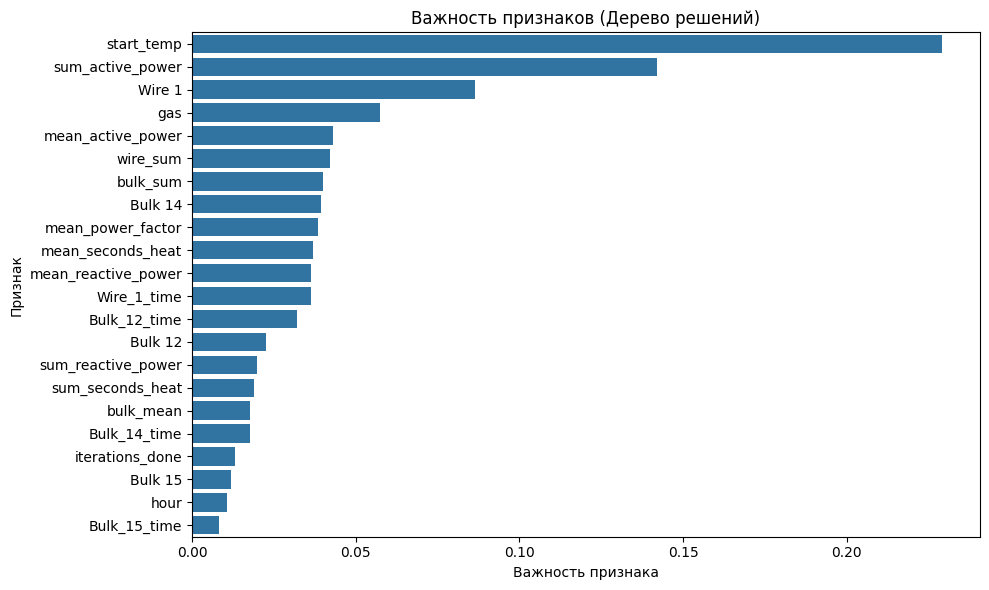

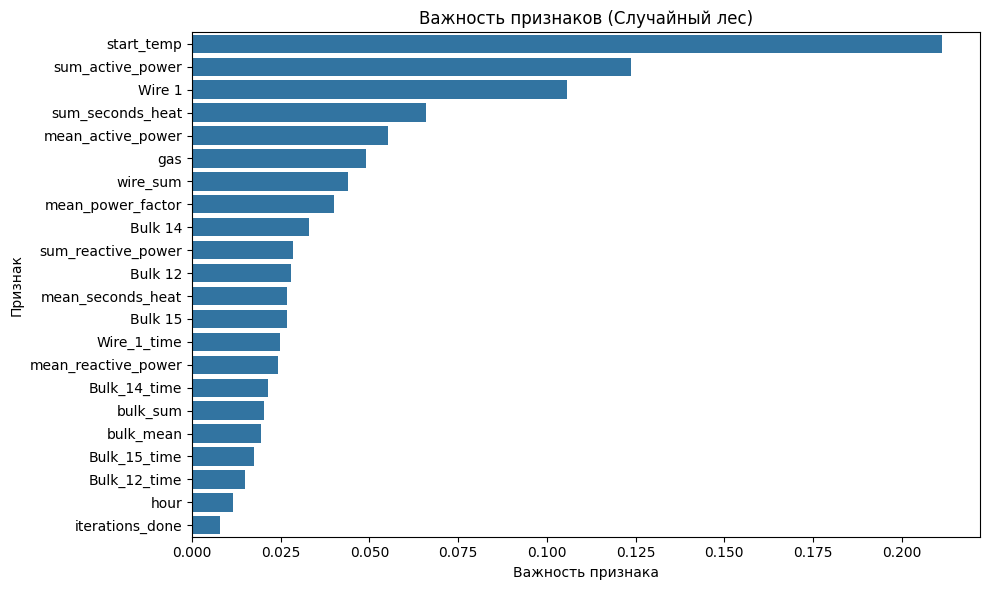


Важность признаков (Дерево решений):
                feature  importance
0            start_temp    0.229213
3      sum_active_power    0.141951
19               Wire 1    0.086359
18                  gas    0.057365
2     mean_active_power    0.042962
20             wire_sum    0.042206
13             bulk_sum    0.039926
11              Bulk 14    0.039405
6     mean_power_factor    0.038505
7     mean_seconds_heat    0.036939
4   mean_reactive_power    0.036214
21          Wire_1_time    0.036197
15         Bulk_12_time    0.031921
10              Bulk 12    0.022554
5    sum_reactive_power    0.019813
8      sum_seconds_heat    0.019051
14            bulk_mean    0.017784
16         Bulk_14_time    0.017671
9       iterations_done    0.013225
12              Bulk 15    0.011783
1                  hour    0.010828
17         Bulk_15_time    0.008128

Важность признаков (Случайный лес):
                feature  importance
0            start_temp    0.211504
3      sum_active_power  

In [ ]:
X, y = unified_data.drop('final_temp', axis=1), unified_data['final_temp']

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X, y)

# Получаем важность признаков из дерева
dt_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

# 2. Использование случайного леса для более стабильной оценки
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Получаем важность признаков из случайного леса
rf_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Создаем функцию для визуализации
def plot_feature_importance(importance_df, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='importance', y='feature')
    plt.title(title)
    plt.xlabel('Важность признака')
    plt.ylabel('Признак')
    plt.tight_layout()
    plt.show()

# Визуализируем результаты
plot_feature_importance(dt_importance, 'Важность признаков (Дерево решений)')
plot_feature_importance(rf_importance, 'Важность признаков (Случайный лес)')

# Выводим численные значения
print("\nВажность признаков (Дерево решений):")
print(dt_importance)
print("\nВажность признаков (Случайный лес):")
print(rf_importance)

Схожий результат. Модели придают важность тем же признакам.

Последний подход для анализа важности — SHAP (SHapley Additive exPlanations).

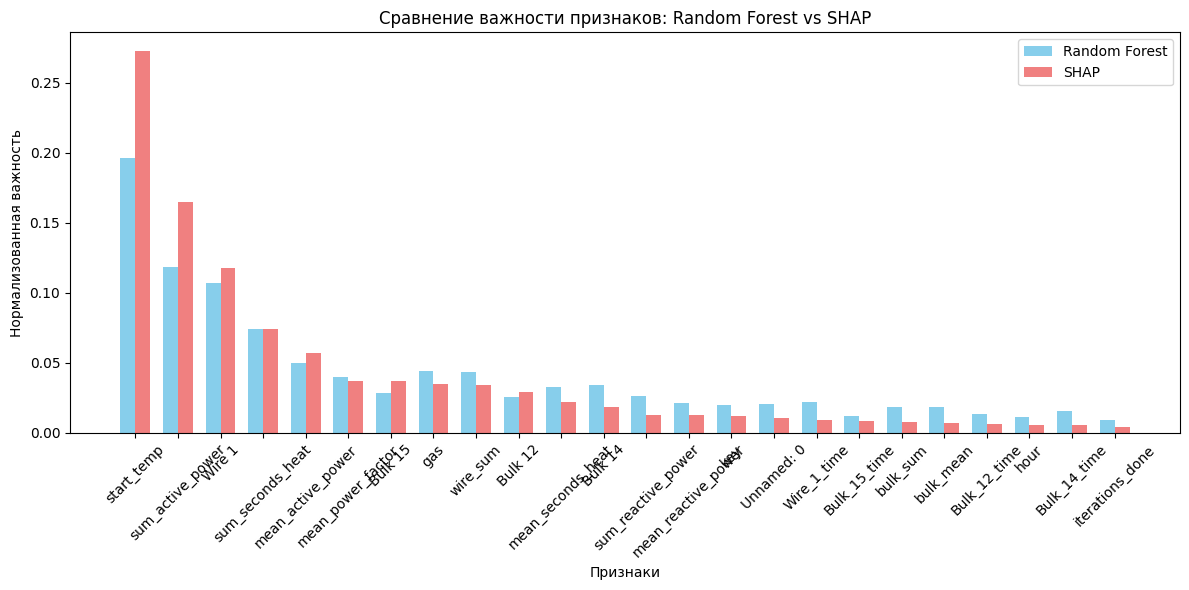

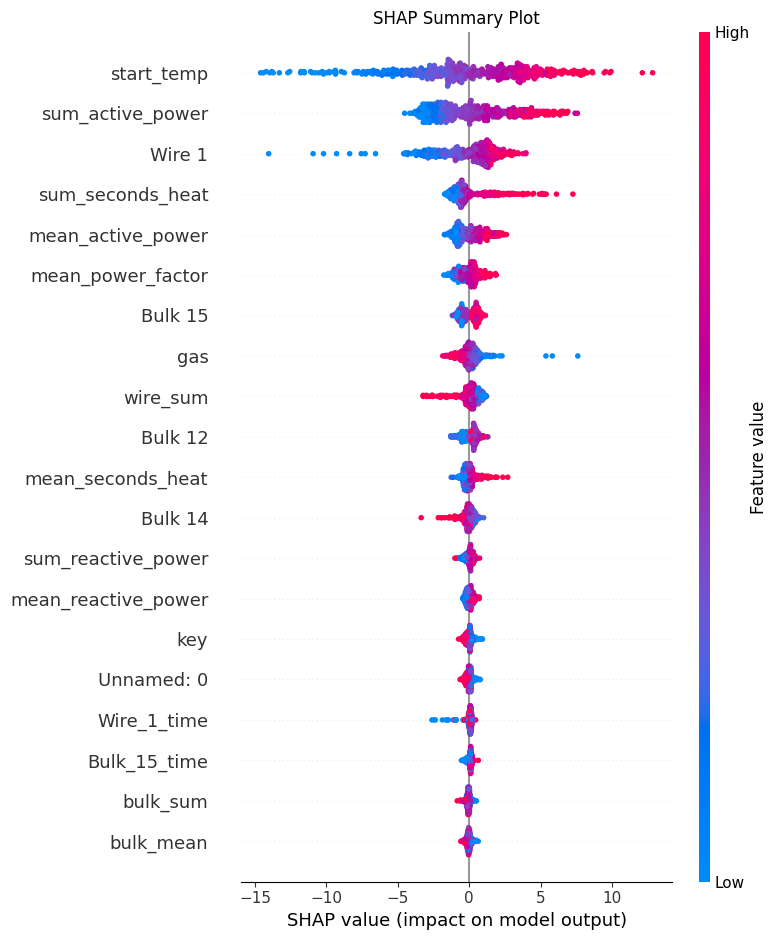

<Figure size 1000x600 with 0 Axes>

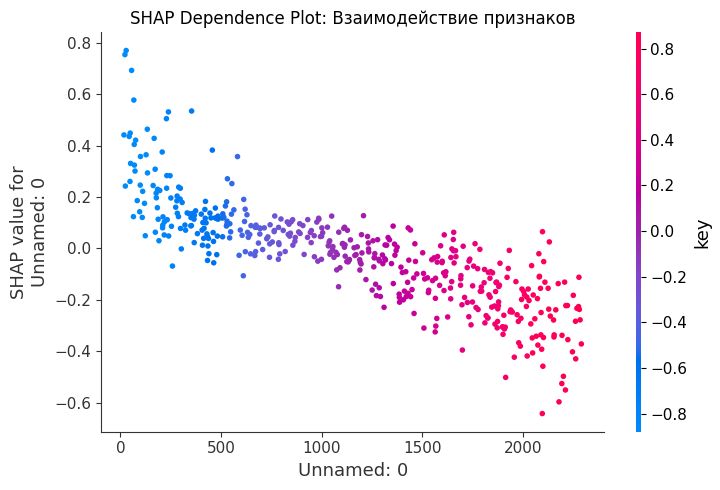


Сравнительный анализ важности признаков:
                feature  rf_importance  shap_importance  rf_importance_norm  \
2            start_temp         0.1965           3.8075              0.1965   
5      sum_active_power         0.1184           2.2992              0.1184   
21               Wire 1         0.1067           1.6482              0.1067   
10     sum_seconds_heat         0.0740           1.0357              0.0740   
4     mean_active_power         0.0501           0.7979              0.0501   
8     mean_power_factor         0.0396           0.5184              0.0396   
14              Bulk 15         0.0281           0.5174              0.0281   
20                  gas         0.0439           0.4849              0.0439   
22             wire_sum         0.0437           0.4771              0.0437   
12              Bulk 12         0.0253           0.4072              0.0253   
9     mean_seconds_heat         0.0323           0.3083              0.0323   
13        

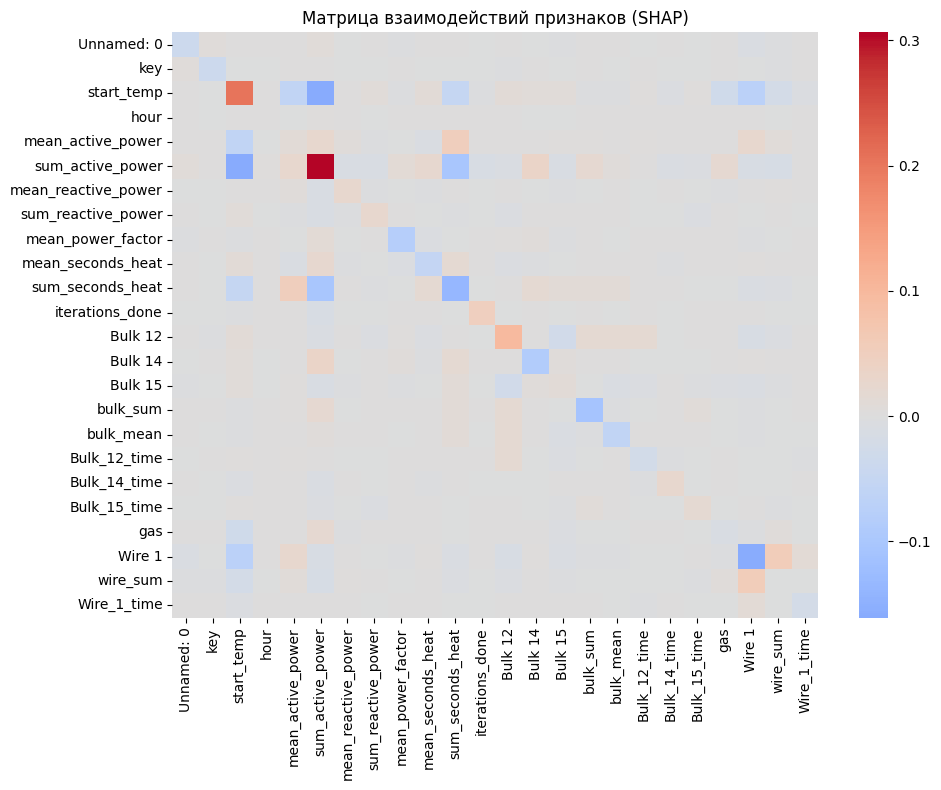

In [ ]:
np.random.seed(42)

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем модель
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Вычисляем SHAP значения
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Функция для комплексного анализа важности признаков
def analyze_feature_importance_advanced(X_test, shap_values, rf_model):
    # 1. Стандартная важность признаков из случайного леса
    rf_importance = pd.DataFrame({
        'feature': X_test.columns,
        'rf_importance': rf_model.feature_importances_
    })

    # 2. SHAP важность (среднее абсолютное значение SHAP)
    shap_importance = pd.DataFrame({
        'feature': X_test.columns,
        'shap_importance': np.abs(shap_values).mean(axis=0)
    })

    # 3. Объединяем результаты
    importance_comparison = rf_importance.merge(shap_importance, on='feature')

    # Нормализуем значения для сравнимости
    importance_comparison['rf_importance_norm'] = (
        importance_comparison['rf_importance'] / importance_comparison['rf_importance'].sum()
    )
    importance_comparison['shap_importance_norm'] = (
        importance_comparison['shap_importance'] / importance_comparison['shap_importance'].sum()
    )

    # Сортируем по SHAP важности
    importance_comparison = importance_comparison.sort_values('shap_importance_norm', ascending=False)

    # Визуализация сравнения важностей
    plt.figure(figsize=(12, 6))

    x = np.arange(len(importance_comparison))
    width = 0.35

    plt.bar(x - width/2, importance_comparison['rf_importance_norm'],
            width, label='Random Forest', color='skyblue')
    plt.bar(x + width/2, importance_comparison['shap_importance_norm'],
            width, label='SHAP', color='lightcoral')

    plt.xlabel('Признаки')
    plt.ylabel('Нормализованная важность')
    plt.title('Сравнение важности признаков: Random Forest vs SHAP')
    plt.xticks(x, importance_comparison['feature'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # SHAP summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title('SHAP Summary Plot')
    plt.tight_layout()
    plt.show()

    # Анализ взаимодействий
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        X_test.columns[0], shap_values, X_test,
        interaction_index=X_test.columns[1],
        show=False
    )
    plt.title('SHAP Dependence Plot: Взаимодействие признаков')
    plt.tight_layout()
    plt.show()

    return importance_comparison

# Проводим анализ
importance_results = analyze_feature_importance_advanced(X_test, shap_values, rf_model)

# Выводим результаты анализа
print("\nСравнительный анализ важности признаков:")
print(importance_results.round(4))

# Анализ взаимодействий признаков
interaction_values = shap.TreeExplainer(rf_model).shap_interaction_values(X_test.iloc[:100])
np.fill_diagonal(interaction_values.mean(0), 0)

plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(
    interaction_values.mean(0),
    columns=X_test.columns,
    index=X_test.columns
), cmap='coolwarm', center=0)
plt.title('Матрица взаимодействий признаков (SHAP)')
plt.tight_layout()
plt.show()

Результаты незначительно отличаются. Некоторые признаки получили больше важности, но в целом картина не изменилась.

In [ ]:
'''
importance_results_7 = list(importance_results['feature'].iloc[:7])
unified_data_upd = unified_data[importance_results_7].join(y)
print(unified_data_upd)
'''

      start_temp    Wire_1   Bulk_15    Bulk_4    Wire_2  mean_power_factor  \
0      -0.262411 -0.636347 -0.239506  0.763313 -1.000000           0.801503   
1      -0.120567 -0.418419 -0.239506  0.849531 -1.000000           0.816691   
2       0.134752 -0.448040 -0.244444  0.718797 -1.000000           0.849959   
3       0.163121 -0.460735 -0.239506  0.864389 -1.000000           0.826323   
4      -0.191489 -0.459677 -0.249383  0.859070  0.500161           0.740490   
...          ...       ...       ...       ...       ...                ...   
2293   -0.276596 -0.460206  0.101235 -1.000000 -1.000000           0.609055   
2294   -0.191489 -0.308662  0.116049  0.827362 -1.000000           0.751374   
2295   -0.262411 -0.430320  0.116049  0.871063  0.498016           0.347222   
2296    0.021277 -0.284859  0.022222 -1.000000 -1.000000           0.730487   
2297   -0.290780 -0.332993  0.120988 -1.000000  0.849448           0.745179   

      sum_reactive_power  final_temp  
0           

# 4. Разработка моделей

Рассмотрим разные виды моделей:
* Решающие деревья
* Модели на основе градиентного бустинга
* Нейросети



In [ ]:
unified_data = pd.read_csv('/content/drive/MyDrive/Datasets/steel_production_project/unified_data_2.csv')
unified_data = unified_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

## Решающие деревья

In [ ]:
X, y = unified_data.drop('final_temp', axis=1), unified_data['final_temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
def objective_decision_tree(trial):
    # Определяем пространство гиперпараметров
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'criterion': trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error'])
    }

    # Создаем модель с текущими параметрами
    model = DecisionTreeRegressor(random_state=42, **params)

    # Проводим кросс-валидацию
    scores = cross_val_score(
        model,
        X,
        y,
        cv=5,
        scoring='neg_mean_absolute_error'
    )

    # Возвращаем среднее значение MAE
    return -scores.mean()

# Функция для оптимизации Random Forest
def objective_random_forest(trial):
    # Определяем пространство гиперпараметров
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'criterion': trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    # Создаем модель с текущими параметрами
    model = RandomForestRegressor(random_state=42, **params)

    # Проводим кросс-валидацию
    scores = cross_val_score(
        model,
        X,
        y,
        cv=5,
        scoring='neg_mean_absolute_error'
    )

    # Возвращаем среднее значение MAE
    return -scores.mean()

def run_optimization(n_trials=100):
    # Создаем исследование для Decision Tree
    study_dt = optuna.create_study(direction='minimize')
    study_dt.optimize(objective_decision_tree, n_trials=n_trials)

    print("\nЛучшие параметры для Decision Tree:")
    print(study_dt.best_params)
    print(f"Лучшее значение MAE: {study_dt.best_value:.4f}")

    # Создаем исследование для Random Forest
    study_rf = optuna.create_study(direction='minimize')
    study_rf.optimize(objective_random_forest, n_trials=n_trials)

    print("\nЛучшие параметры для Random Forest:")
    print(study_rf.best_params)
    print(f"Лучшее значение MAE: {study_rf.best_value:.4f}")

    return study_dt, study_rf

# Визуализация результатов
def plot_optimization_history(study_dt, study_rf):
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # График для Decision Tree
    optuna.visualization.plot_optimization_history(study_dt).update_layout(
        title="Optimization History (Decision Tree)"
    )

    # График для Random Forest
    optuna.visualization.plot_optimization_history(study_rf).update_layout(
        title="Optimization History (Random Forest)"
    )

    plt.tight_layout()
    plt.show()

In [ ]:
study_dt, study_rf = run_optimization(n_trials=50)

[I 2024-11-18 10:46:27,893] A new study created in memory with name: no-name-8d42fd57-5f64-48f4-9fc2-d7ede2871375
[I 2024-11-18 10:46:28,013] Trial 0 finished with value: 12.962700273175198 and parameters: {'max_depth': 31, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'log2', 'criterion': 'squared_error'}. Best is trial 0 with value: 12.962700273175198.
[I 2024-11-18 10:46:28,112] Trial 1 finished with value: 11.435373594228592 and parameters: {'max_depth': 27, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2', 'criterion': 'squared_error'}. Best is trial 1 with value: 11.435373594228592.
[I 2024-11-18 10:46:28,520] Trial 2 finished with value: 10.33270720848726 and parameters: {'max_depth': 31, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'criterion': 'absolute_error'}. Best is trial 2 with value: 10.33270720848726.
[I 2024-11-18 10:46:28,663] Trial 3 finished with value: 12.000499856727682 and parameters: {'max_depth'


Лучшие параметры для Decision Tree:
{'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 'log2', 'criterion': 'absolute_error'}
Лучшее значение MAE: 9.7293


[I 2024-11-18 10:48:53,615] Trial 0 finished with value: 9.044956369753887 and parameters: {'n_estimators': 488, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'criterion': 'absolute_error', 'bootstrap': False}. Best is trial 0 with value: 9.044956369753887.
[I 2024-11-18 10:50:25,544] Trial 1 finished with value: 8.989707019996311 and parameters: {'n_estimators': 495, 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'log2', 'criterion': 'absolute_error', 'bootstrap': True}. Best is trial 1 with value: 8.989707019996311.
[I 2024-11-18 10:50:30,317] Trial 2 finished with value: 9.385147048317968 and parameters: {'n_estimators': 350, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2', 'criterion': 'poisson', 'bootstrap': True}. Best is trial 1 with value: 8.989707019996311.
[I 2024-11-18 10:50:41,140] Trial 3 finished with value: 9.107306769437029 and parameters: {'n_estimators': 4

KeyboardInterrupt: 

Лучшие параметры для v1:

In [ ]:
# Лучшие параметры для Decision Tree:
dt_v1_best_params = {'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2', 'criterion': 'absolute_error'}
# Лучшее значение MSE: 9.6264

# Лучшие параметры для Random Forest:
rf_v2_best_params = {'n_estimators': 165, 'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'absolute_error', 'bootstrap': False}
# Лучшее значение MSE: 8.9699

Лучшие параметры для v2:

In [ ]:
# Лучшие параметры для Decision Tree:
dt_v2_best_params = {'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'criterion': 'squared_error'}
# Лучшее значение MAE: 7.8053

#Лучшие параметры для Random Forest:
rf_v2_best_params = {'n_estimators': 332, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'poisson', 'bootstrap': False}
# Лучшее значение MAE: 6.4689

Проверим качество на тестовых данных:

In [ ]:
DTR = DecisionTreeRegressor(max_depth=4, min_samples_split=6, min_samples_leaf=8, max_features='sqrt', criterion='squared_error', random_state=42)

RFR = RandomForestRegressor(n_estimators=332, max_depth=18, min_samples_split=7, min_samples_leaf=2, max_features='sqrt', criterion='poisson', bootstrap=False, random_state=42)

DTR.fit(X_train, y_train)
RFR.fit(X_train, y_train)

DTR_pred = DTR.predict(X_test)
RFR_pred = RFR.predict(X_test)

print(f'Decision Tree MAE: {mean_absolute_error(y_test, DTR_pred)}')
print(f'Random Forest MAE: {mean_absolute_error(y_test, RFR_pred)}')
print(f'Decision Tree R2: {r2_score(y_test, DTR_pred)}')
print(f'Random Forest R2: {r2_score(y_test, RFR_pred)}')

Decision Tree MAE: 7.981244115507337
Random Forest MAE: 6.39745539822023
Decision Tree R2: 0.08899219408138093
Random Forest R2: 0.3951885414252302


v1:

* Decision Tree MAE: 9.904347826086957
* Random Forest MAE: 8.948189723320159
* Decision Tree R2: 0.04513235103317326
* Random Forest R2: 0.2219282129420248

Исходя из метрики r2, модели чуть лучше случайных. MAE неудовлетворительное, требуемое MAE — 6.8 и менее. . Используемые признаки в v1:

In [ ]:
print(list(importance_results['feature'].iloc[:7]))

['start_temp', 'Wire_1', 'Bulk_15', 'Bulk_4', 'Wire_2', 'mean_power_factor', 'sum_reactive_power']


v2:
* Decision Tree MAE: 7.981244115507337
* Random Forest MAE: 6.39745539822023
* Decision Tree R2: 0.08899219408138093
* Random Forest R2: 0.3951885414252302

После повторного анализа, создания новых, а также использования всех доступных признаков повысили метрики качества.

In [ ]:
print('Используемые признаки в v2:', unified_data.columns.values)

Используемые признаки в v2: ['key' 'start_temp' 'hour' 'mean_active_power' 'sum_active_power'
 'mean_reactive_power' 'sum_reactive_power' 'mean_power_factor'
 'mean_seconds_heat' 'sum_seconds_heat' 'iterations_done' 'Bulk 12'
 'Bulk 14' 'Bulk 15' 'bulk_sum' 'bulk_mean' 'Bulk_12_time' 'Bulk_14_time'
 'Bulk_15_time' 'gas' 'Wire 1' 'wire_sum' 'Wire_1_time' 'final_temp']


## Модели градиентного бустинга

Будем рассматривать три основные разновидности:
* CatBoost
* LightGBM
* XGBoost

In [ ]:
class BoostingModelsOptimizer:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.best_params = {}
        self.best_scores = {}
        self.best_models = {}

    def _get_metric(self, y_true, y_pred): # Задаем метрику, которую нужно минимизировать
        return mean_absolute_error(y_true, y_pred)

    def optimize_catboost(self, X_train, X_val, y_train, y_val, n_trials=100):
        def objective(trial):
            params = {
              'iterations': trial.suggest_int('iterations', 100, 1000),
              'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
              'depth': trial.suggest_int('depth', 4, 10),
              'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=True),
              'random_seed': self.random_state
          }

            model = CatBoostRegressor(**params, verbose=False)
            model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

            y_pred = model.predict(X_val)

            score = self._get_metric(y_val, y_pred)
            return score

        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials)

        self.best_params['catboost'] = study.best_params
        self.best_models['catboost'] = CatBoostRegressor(**study.best_params, random_seed=self.random_state)

        return study.best_params

    def optimize_lightgbm(self, X_train, X_val, y_train, y_val, n_trials=100):
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
                'num_leaves': trial.suggest_int('num_leaves', 20, 150),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'random_state': self.random_state
            }

            model = LGBMRegressor(**params, verbosity=-1)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[log_evaluation(0)])

            y_pred = model.predict(X_val)

            score = self._get_metric(y_val, y_pred)
            return score

        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials)

        self.best_params['lightgbm'] = study.best_params
        self.best_models['lightgbm'] = LGBMRegressor(**study.best_params, random_state=self.random_state)

        return study.best_params

    def optimize_xgboost(self, X_train, X_val, y_train, y_val, n_trials=100):
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'min_child_weight': trial.suggest_float('min_child_weight', 1e-8, 100.0, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'random_state': self.random_state
            }

            model = XGBRegressor(**params)

            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

            y_pred = model.predict(X_val)

            score = self._get_metric(y_val, y_pred)
            return score

        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials)

        self.best_params['xgboost'] = study.best_params
        self.best_models['xgboost'] = XGBRegressor(**study.best_params, random_state=self.random_state)

        return study.best_params

    def optimize_all(self, X, y, test_size=0.2, n_trials=10):
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state
        )

        results = {}
        results['catboost'] = self.optimize_catboost(X_train, X_val, y_train, y_val, n_trials)
        results['lightgbm'] = self.optimize_lightgbm(X_train, X_val, y_train, y_val, n_trials)
        results['xgboost'] = self.optimize_xgboost(X_train, X_val, y_train, y_val, n_trials)

        return results

optimizer = BoostingModelsOptimizer()
best_params = optimizer.optimize_all(X, y, n_trials=10)

[I 2024-11-20 12:55:26,636] A new study created in memory with name: no-name-723e2cc1-2d7c-4fea-84c4-b8d2e8fb1909
[I 2024-11-20 12:55:29,332] Trial 0 finished with value: 6.295114548967136 and parameters: {'iterations': 586, 'learning_rate': 0.014292645381089108, 'depth': 4, 'l2_leaf_reg': 2.8875254040391093e-07}. Best is trial 0 with value: 6.295114548967136.
[I 2024-11-20 12:55:33,402] Trial 1 finished with value: 6.918446477335128 and parameters: {'iterations': 301, 'learning_rate': 0.003946965798323536, 'depth': 7, 'l2_leaf_reg': 0.0008906907524857649}. Best is trial 0 with value: 6.295114548967136.
[I 2024-11-20 12:55:35,346] Trial 2 finished with value: 6.966259341602045 and parameters: {'iterations': 535, 'learning_rate': 0.004621943960145052, 'depth': 5, 'l2_leaf_reg': 73.50445766105258}. Best is trial 0 with value: 6.295114548967136.
[W 2024-11-20 12:55:45,442] Trial 3 failed with parameters: {'iterations': 801, 'learning_rate': 0.0021945012344247554, 'depth': 9, 'l2_leaf_reg'

KeyboardInterrupt: 

Проверка на тестовых данных:

In [ ]:
catboost_v1 = CatBoostRegressor(iterations=287, learning_rate=0.009579952848816077, depth=8, l2_leaf_reg=0.024661433678578912)
lightgbm_v1 = LGBMRegressor(n_estimators=466, learning_rate=0.006782383555857317, num_leaves=70, max_depth=8, min_child_samples=42)
xgboost_v1 = XGBRegressor(n_estimators=222, learning_rate=0.009085267433577703, max_depth=8, min_child_weight=10.444182387122837, subsample=0.6256014394139672, colsample_bytree=0.7846308629380947)

catboost_v1.fit(X_train, y_train, verbose=0)
lightgbm_v1.fit(X_train, y_train)
xgboost_v1.fit(X_train, y_train)

catboost_v1_pred = catboost_v1.predict(X_test)
lightgbm_v1_pred = lightgbm_v1.predict(X_test)
xgboost_v1_pred = xgboost_v1.predict(X_test)


catboost_v2 = CatBoostRegressor(iterations=402, learning_rate=0.05761277642021725, depth=7, l2_leaf_reg=1.6597739904877495)
lightgbm_v2 = LGBMRegressor(n_estimators=551, learning_rate=0.04792026231278263, num_leaves=66, max_depth=5, min_child_samples=13)
xgboost_v2 = XGBRegressor(n_estimators=924, learning_rate=0.0077340824811069275, max_depth=6, min_child_weight=1.8468608916360778e-05, subsample=0.5315926825190866, colsample_bytree=0.7033354336400574)

catboost_v2.fit(X_train, y_train, verbose=0)
lightgbm_v2.fit(X_train, y_train)
xgboost_v2.fit(X_train, y_train)

catboost_v2_pred = catboost_v2.predict(X_test)
lightgbm_v2_pred = lightgbm_v2.predict(X_test)
xgboost_v2_pred = xgboost_v2.predict(X_test)

print(f'catboost_v1 MAE: {mean_absolute_error(y_test, catboost_v1_pred)}')
print(f'lightgbm_v1 MAE: {mean_absolute_error(y_test, lightgbm_v1_pred)}')
print(f'xgboost_v1 MAE: {mean_absolute_error(y_test, xgboost_v1_pred)}')

print(f'catboost_v1 R2: {r2_score(y_test, catboost_v1_pred)}')
print(f'lightgbm_v1 R2: {r2_score(y_test, lightgbm_v1_pred)}')
print(f'xgboost_v1 R2: {r2_score(y_test, xgboost_v1_pred)}')

print(f'catboost_v2 MAE: {mean_absolute_error(y_test, catboost_v2_pred)}')
print(f'lightgbm_v2 MAE: {mean_absolute_error(y_test, lightgbm_v2_pred)}')
print(f'xgboost_v2 MAE: {mean_absolute_error(y_test, xgboost_v2_pred)}')

print(f'catboost_v2 R2: {r2_score(y_test, catboost_v2_pred)}')
print(f'lightgbm_v2 R2: {r2_score(y_test, lightgbm_v2_pred)}')
print(f'xgboost_v2 R2: {r2_score(y_test, xgboost_v2_pred)}')

catboost_v1 MAE: 6.518521632288353
lightgbm_v1 MAE: 6.21801522017655
xgboost_v1 MAE: 6.3245445543880665
catboost_v1 R2: 0.37470053136387116
lightgbm_v1 R2: 0.42358831899618765
xgboost_v1 R2: 0.4101256593959127
catboost_v2 MAE: 6.213920482814665
lightgbm_v2 MAE: 6.259628767833385
xgboost_v2 MAE: 6.0972005066555965
catboost_v2 R2: 0.41335964211346854
lightgbm_v2 R2: 0.4228344297043043
xgboost_v2 R2: 0.43712271552796544


## Нейросеть

В наших данных есть признаки времени, однако, как показал анализ, время обработки не является важным признаком. Исходя из этого, нам скорее всего не подойдут архитектуры нейросетей RNN и трансформеры, так как последовательности в данных не имеют значения. Попробуем обычный перцептрон.

Epoch [10/300], Train Loss: 1587.8027, Val Loss: 1584.6260
Epoch [20/300], Train Loss: 1570.4686, Val Loss: 1565.7515
Epoch [30/300], Train Loss: 1543.6568, Val Loss: 1541.8810
Epoch [40/300], Train Loss: 1508.7000, Val Loss: 1505.1690
Epoch [50/300], Train Loss: 1466.5887, Val Loss: 1463.7205
Epoch [60/300], Train Loss: 1417.9645, Val Loss: 1414.4404
Epoch [70/300], Train Loss: 1363.2713, Val Loss: 1368.8635
Epoch [80/300], Train Loss: 1302.8056, Val Loss: 1295.3714
Epoch [90/300], Train Loss: 1236.7832, Val Loss: 1226.6292
Epoch [100/300], Train Loss: 1165.3308, Val Loss: 1155.3301
Epoch [110/300], Train Loss: 1088.5836, Val Loss: 1078.1202
Epoch [120/300], Train Loss: 1006.5696, Val Loss: 998.0184
Epoch [130/300], Train Loss: 919.3957, Val Loss: 907.3812
Epoch [140/300], Train Loss: 827.0303, Val Loss: 814.3305
Epoch [150/300], Train Loss: 729.5848, Val Loss: 717.9251
Epoch [160/300], Train Loss: 627.0360, Val Loss: 611.0348
Epoch [170/300], Train Loss: 519.4314, Val Loss: 509.5840


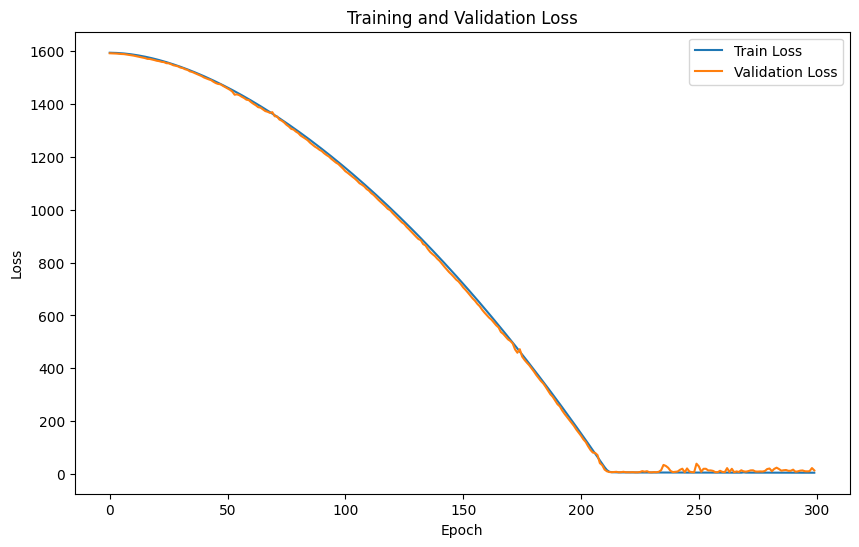

In [ ]:
# Создание класса, делающего наши данные совместимыми с DataLoader
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Определяем архитектуру нейронной сети
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes=[64, 32, 16, 8]):
        super(MLP, self).__init__()

        # Создаем список слоев
        layers = []

        # Входной слой
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        #layers.append(nn.Dropout(0.2))

        # Скрытые слои
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_sizes[i+1]))
            #layers.append(nn.Dropout(0.2))

        # Выходной слой
        layers.append(nn.Linear(hidden_sizes[-1], 1))

        # Объединяем слои в последовательную модель
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Функция обучения модели
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Режим обучения
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # Валидация
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                val_loss += loss.item()

        epoch_val_loss = val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {epoch_train_loss:.4f}, '
                  f'Val Loss: {epoch_val_loss:.4f}')

    return train_losses, val_losses

# Пример использования

# Разделяем данные на обучающую и валидационную выборки
train_size = int(0.75 * len(X))
X_train, X_val = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_val = y.iloc[:train_size], y.iloc[train_size:]

# Нормализуем данные если требуется, наши уже нормализованы
'''
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
'''

# Создаем даталоадеры
train_dataset = RegressionDataset(X_train, y_train)
val_dataset = RegressionDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Определяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Создаем модель
model = MLP(input_size=23).to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучаем модель
train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=300,
    device=device
)

# Визуализируем процесс обучения
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Эксперименты для v1:

Параметры обучения 1:
* num_epochs = 300
* dropout = 0.2
* BatchNorm1d = True

Train Loss: 155.5305, Val Loss: 24.1257

Признаки недообучения. Уберем dropout.

Параметры обучения 2:
* num_epochs = 300
* dropout = 0
* BatchNorm1d = True

Train Loss: 9.3937, Val Loss: 11.2636


Параметры обучения 3:
* num_epochs = 300
* dropout = 0
* BatchNorm1d = False
* Добавлен еще один полносвязный слой с 8 нейронами

Train Loss: 9.3819, Val Loss: 9.9130



In [ ]:
model.eval()

# Отключаем вычисление градиентов
with torch.no_grad():
    # Подготовка новых данных для предсказания
    new_data = torch.FloatTensor(X_test.to_numpy()).to(device)

    # Получение предсказаний
    predictions = model(new_data)

    # Преобразование в numpy для дальнейшей работы
    predictions = predictions.cpu().numpy()

In [ ]:
print(mean_absolute_error(y_test, predictions))

10.442405103600544


Лучшая MAE на тестовой выборке: 10.442405103600544


### Эксперименты для v2:

Параметры обучения 1:
* num_epochs = 300
* dropout = 0.2
* BatchNorm1d = True

Train Loss: 151.4375, Val Loss: 24.8367

Недообучение.


Параметры обучения 2:
* num_epochs = 300
* dropout = 0
* BatchNorm1d = True

Train Loss: 4.7554, Val Loss: 7.8500

Хороший результат на тренировочной выборке, но хуже на валидационной.

Параметры обучения 3:
* num_epochs = 300
* dropout = 0
* BatchNorm1d = False

Train Loss: 7.0405, Val Loss: 7.5618


Параметры обучения 4:
* num_epochs = 300
* dropout = 0
* BatchNorm1d = True
* Добавлен еще один полносвязный слой с 8 нейронами

Train Loss: 5.2636, Val Loss: 6.6596

Незначительное увеличение качества.

In [ ]:
model.eval()

# Отключаем вычисление градиентов
with torch.no_grad():
    # Подготовка новых данных для предсказания
    new_data = torch.FloatTensor(X_test.to_numpy()).to(device)

    # Получение предсказаний
    predictions = model(new_data)

    # Преобразование в numpy для дальнейшей работы
    predictions = predictions.cpu().numpy()

In [ ]:
print(mean_absolute_error(y_test, predictions))

6.085457512725936


Лучшее MAE на тестовой выборке: 6.085457512725936

## Результаты обучения моделей

In [ ]:
models_data = {'decision tree': [9.6264, 7.8053], 'random forest': [8.9699, 6.4689], 'catboost': [6.5185, 6.2139], 'lightgbm': [6.2180, 6.2596], 'xgboost': [6.3245, 6.0972], 'mlp': [10.4424, 6.0854]}
models_tab = pd.DataFrame(data=models_data, index=['v1', 'v2'])
display(models_tab)

decision tree  random forest  catboost  lightgbm  xgboost      mlp
v1         9.6264         8.9699    6.5185    6.2180   6.3245  10.4424
v2         7.8053         6.4689    6.2139    6.2596   6.0972   6.0854

# Заключение

#### **Описание выполненного проекта**

В рамках проекта были проведены многоэтапные исследования, направленные на анализ и обработку данных. Основные достижения включают:

* Исследование природы каждого признака в каждой таблице.
* Визуализацию закономерностей и распределений признаков.
* Создание новых, значимых признаков.
* Масштабирование данных с учетом их особенностей.
* Оценку значимости признаков.
* Разработку и обучение моделей.

#### **Работа с данными**
Анализировались два набора данных:

1. Версия, включающая семь наиболее важных признаков, отобранных с помощью анализа SHAP.
2. Полный набор данных, включающий все исходные признаки, а также созданные дополнительные.


#### **Основные вызовы**
В процессе выполнения работы возникли следующие сложности:

* Сложность понимания производственного процесса. Понимание особенностей процесса производства требовало значительных усилий, что затрудняло планирование и реализацию проекта.
* Отсутствие линейных взаимосвязей с целевым признаком.
Данные не демонстрировали выраженных линейных зависимостей, что делало невозможным построение моделей, основанных на предположении о линейной связи. Для преодоления этой проблемы был выполнен анализ, направленный на создание новых, более значимых признаков, а также создание моделей, способных хорошо работать с нелинейными зависимостями.

* Особенности временных признаков.
Признаки содержали информацию о времени, но не о дате, что вызывало сложности при интерпретации. При этом данные включали более 3000 партий продукции. В случае, если данные относятся к одному дню, временные признаки могут быть значимыми. Однако производственная возможность выпуска более 3000 партий заготовок стали за сутки вызывает сомнения.

#### **Вывод**
Несмотря на указанные вызовы, проект был выполнен успешно. Разработанные подходы и решения позволили достичь поставленных целей и обеспечить высокий уровень качества результатов.
